# Imports

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
import gc
import copy
import glob
import os
import torch
import transformers
from os.path import dirname, basename
import copy

from collections import Counter, OrderedDict
import random
import pickle
import math
import matplotlib.pyplot as pl
import utils_nlg_v3
# from train_nlg import NLG, TrainingModule
import json
import itertools

## Imports for A1) Controlling Text Length
import os
import sys

# Docker Images Parser and RST tree labeller
mp1 = os.path.abspath(os.path.join('..'))
mp2 = "../DockerImages/feng_hirst_rst_parser"
mp3 = "../DockerImages/feng_hirst_rst_parser/src"
mp4 = "../DockerImages/feng_hirst_rst_parser/model"
modules_paths = [mp1, mp2, mp3, mp4]

for mp in modules_paths:
    if mp not in sys.path:
        sys.path.append(mp)

from DockerImages.feng_hirst_rst_parser.src.parse2 import DiscourseParser


import nltk
nltk.download('stopwords')
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
## ------------------------ ##

## --- Imports for the attention viewing code
from bertviz import head_view


## -- Imports e_coherency
import math
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from transformers import CTRLTokenizer, CTRLLMHeadModel

# --- Imports d
%matplotlib inline
import regex as re
import sklearn as skl
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

# ---- Imports R1
import rake_nltk
import pytextrank
import spacy
import en_core_web_sm
import pke
from nltk.corpus import stopwords
from seg_bot_segmenter import Segmenter, Lang, PointerNetworks


import en_core_web_sm

#nlp = spacy.load("en_core_web_sm")
#tr = pytextrank.TextRank()
import string

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/akann1w0w1ck/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
class Data_Sampler():
    """
        This Provides the ability to sample from RST structure trees
        
        Can sample RST structure by multiple factors
        
            Factor 1 - Subreddit
            Factor 2 - Length of RST, by number of nodes
            Factor 3 - Contains a specific number of a certain RST relations
                        
    """
    def __init__(self, 
                 dir_dsets="./dataset_v2/reddit_large_annotated",
                rst_restore_dir="./RST_sampler"):
        
        self.dir_dsets = dir_dsets
        self.load_subreddit_fps()
        self.rst_restore_dir = rst_restore_dir
        
        self.restore_queries()
        
    def restore_queries(self):
        self.query_fp = os.path.join( self.rst_restore_dir, 'dict_querynumb_encodedquery.json' ) 
        
        if os.path.exists( self.query_fp ):
            self.dict_querynumb_encodedquery = json.load( open(self.query_fp, 'r') )
        else:
            os.makedirs( self.rst_restore_dir, exist_ok=True)
            os.makedirs( os.path.join( self.rst_restore_dir, "saved_dsets") , exist_ok=True)
            self.dict_querynumb_encodedquery = {}
                        
    def load_subreddit_fps(self):
        """ loads a list of fns sorted by subreddit name
            
            Use a dictionary with lists to hold the fns
        """
        
        #Finding subreddit names
        self.dict_subreddit_fps = { basename(dirname(path)):path for path in glob.glob(os.path.join(self.dir_dsets,"*","*")) if os.path.split(path)[-1] != "lock"  }
        #print(self.dict_subreddit_fps)
    
    def sample(
                self,
               sample_count= 10,
                li_subreddit=[], 
               li_RST_len=[],
               dict_RSTrel_counts={},
                rst_rel_count_mode='greaterequal_than'):

        dict_subreddit_fps = copy.deepcopy(self.dict_subreddit_fps)

        # filtering
        df = self.filter_from_fps(  dict_subreddit_fps,
                 li_subreddit,
                 li_RST_len,
                 dict_RSTrel_counts,
                rst_only=False,
                rst_rel_count_mode=rst_rel_count_mode) 
        
        # Sampling
        if sample_count>=0:
            adj_sample_count = min(sample_count, len(df) )
            
            li_sample = random.sample(df.values.tolist(), adj_sample_count)
        else:
            li_sample = df.values.tolist()
        
        return li_sample
            
    def sample_rst( self,
               sample_count= 10,
                li_subreddit=[], 
               li_RST_len=[],
               dict_RSTrel_counts={},
                  rst_rel_count_mode='greaterequal_than'):
    
        """
            sample_count: an integer representing the number of samples to draw
            li_subreddit: a list of the subreddit's from which the user wants samples to be drawn
            li_RST_len: a list of numbers - indicating which lengths to include
            dict_RSTrel_counts: a dictionary indicating filtering on the occurece of relations in the Tree
                                each key will be a relation. each value will be a number indicating the minimum number of times this occurence must appear in the RST tree
        """
        li_subreddit.sort()
        
        # Checking if query has been searched already and can be loaded from a saved pickle
        encoded_query = f"scount_{sample_count}__lisreddit_{'x'.join(li_subreddit)}__RSTlen_{'x'.join([str(x) for x in li_RST_len])}__RSTrelcounts_{json.dumps(dict_RSTrel_counts)}"
        bool_loaded = encoded_query in self.dict_querynumb_encodedquery.values()
        
        if bool_loaded == True:
            
            query_code = [k for k,v in self.dict_querynumb_encodedquery.items() if v==encoded_query ][0]
            dset_path = os.path.join(self.rst_restore_dir, "saved_dsets", f"{query_code}.pickle" )
            srs_rsts = pickle.load( open( dset_path, "rb") )
        
        else:
            
            dict_subreddit_fps = copy.deepcopy(self.dict_subreddit_fps)

            srs_rsts = self.filter_from_fps(  dict_subreddit_fps,
                     li_subreddit,
                     li_RST_len,
                     dict_RSTrel_counts,
                    rst_only=True,
                    rst_rel_count_mode=rst_rel_count_mode) 
            
            # Saving Filtered pandas series to pickle
                # Each new pickle file is simply labelled an increment value of the largest number in the directory e.g. 001.pickle. 002.piclkle e.g.
                # We then hold a dictionary which maps these filenames to the actual 
            query_code = f"{len(self.dict_querynumb_encodedquery)+1:03d}"
            
            path_ = os.path.join(self.rst_restore_dir, "saved_dsets", f"{query_code}.pickle" )
            pickle.dump(srs_rsts, open(path_,"wb"))
            
            self.dict_querynumb_encodedquery[ query_code ] =  encoded_query
            json.dump( self.dict_querynumb_encodedquery, open( self.query_fp, 'w') )
            
        # Sampling
        if sample_count>=0:
            li_sample = random.sample(srs_rsts.tolist(), sample_count)
        else:
            li_sample = srs_rsts.tolist()
        
        return li_sample, query_code       
    
    def filter_from_fps(self, 
                    dict_subreddit_fps,
                 li_subreddit,
                 li_RST_len,
                 dict_RSTrel_counts,
                    rst_only=False,
                    rst_rel_count_mode="greaterequal_than"):
        
        #subreddit type filtering
        if len(li_subreddit) != 0:
            dict_subreddit_fps = { k:v for k,v in dict_subreddit_fps.items() if k in li_subreddit }

            # Loading actual records into memory
        if rst_only:
            li_df = [pd.read_csv(v, header=0,squeeze=True, usecols=['rst'] ) for k,v in dict_subreddit_fps.items() ]
        else:
            li_df = [pd.read_csv(v, header=0, usecols=['txt_preproc','rst','topic_textrank' ] ) for k,v in dict_subreddit_fps.items() ]
                        
            # Filtering out data to only include the test set data
            file_sizes = [len(df) for df in li_df]
            test_starts = [int(0.8*val) for val in file_sizes]
            li_df = [ df.iloc[ts:] for df, ts in zip(li_df, test_starts) ]
            
            #parsing the json encoded strings
            if rst_only:
                for df_ in li_df:
                    df[['rst','topic_textrank']] =  df[['rst','topic_textrank']].applymap(func_parse)
            else:
                for df_ in li_df:
                    df_[['txt_preproc','rst','topic_textrank']] = df_[['txt_preproc','rst','topic_textrank']].applymap(lambda x: json.loads(x))
                    

        df = li_df.pop(0)
        df = df.append(li_df, ignore_index=True)
        del li_df
        

        # RST_len filtering            
        if len(li_RST_len) != 0:
            
            def func_rstlenfilt(li_rst_encoding, lengths_to_keep):
                
                bool_ = len(li_rst_encoding) in lengths_to_keep
                return bool_

            if rst_only:
                m = df.parallel_apply(func_rstlenfilt, lengths_to_keep=li_RST_len)
            else: 
                m = df['rst'].apply( lambda x: len(x) in li_RST_len )
            
            df = df[m]


        # RST relation count filtering
        if len(dict_RSTrel_counts) != 0:
            def func_rstrelcountfilt(li_rst_encoding, dict_rst_mincount ):
                rel_counter = Counter( [ dict_['rel'] for dict_ in li_rst_encoding] ) 
                
                if rst_rel_count_mode == "greaterequal_than":
                    bool_ = any( [ rel_counter[rel] >= dict_rst_mincount[rel] for rel in dict_rst_mincount.keys() ] ) 
                
                elif rst_rel_count_mode == "equal_to":
                    bool_ = any( [ rel_counter[rel] == dict_rst_mincount[rel] for rel in dict_rst_mincount.keys() ] ) 
                
                elif rst_rel_count_mode == "lessequal_than":
                    bool_ = any( [ rel_counter[rel] <= dict_rst_mincount[rel] for rel in dict_rst_mincount.keys() ] ) 
                    
                return bool_
            
            if rst_only:
                m = df.parallel_apply(func_rstrelcountfilt, dict_rst_mincount=dict_RSTrel_counts )
            else:
                m = df['rst'].apply(func_rstrelcountfilt, dict_rst_mincount=dict_RSTrel_counts )
                
            df = df[m]


        return df
        
    def rst_statistics_for_query(self,
                li_subreddit=[], 
               li_RST_len=[],
               dict_RSTrel_counts={}):
        """
            Produce RST related statistics for this query
            
            Saves to file information on :
                Tree depth distribution
                For each relation r, the distribution of r's occurences in each utterance
                The average number of times each relation occurs in the dataset
                
                                
        """

        # Gathering Sample
        li_sample,query_code = self.sample_rst( sample_count=-1,
                li_subreddit=li_subreddit, 
               li_RST_len=li_RST_len,
               dict_RSTrel_counts={})
        
        #Setting up directory to save RST statistics
        save_dir = os.path.join(self.rst_restore_dir, "RST_stats", query_code )
        os.makedirs(save_dir, exist_ok=True)
        
        # Saving the related queries that form these stats
        dict_query_details = {
            'subreddits_filter':li_subreddit, 
               'RST_len_filter':li_RST_len,
               'RSTrel_counts_filter':dict_RSTrel_counts
        }
        
        json.dump(dict_query_details, open( os.path.join(save_dir, "query_details.json"), "w") )
        
                
        # Saving Depth Distribution Chart
        li_rst_last_pos = [ [_dict['pos'] for _dict in li_][-1] for li_ in li_sample ]
        li_rst_depths = [ int( math.log( pos+2, 2) ) for pos in li_rst_last_pos  ]
                
        pl_hist = pl.hist(li_rst_depths, bins=list(range(max(li_rst_depths))), density=True )
        pl.title('RST Binary Tree Depth Distribution')
        pl.xlabel("Depth")
        pl.ylabel("Density")
        pl.savefig( os.path.join(save_dir, "rst_depth_distribution.png"),dpi=600 )
        pl.close()
        
              
        # Saving Occurence statistics for each relation 
            # First Converting each utterance into a dictionary recording the count of each rst relation occurence in a specific utterace
        li_utterance_relscntr = [ Counter([ _dict['rel'] for _dict in li_ ] ) for li_ in li_sample ]  # a list of relation counts for each utterance in sample
        
            # getting distribution for each RST relation, of the number of times an RSt relation occurs in an utterance
        li_rels = utils_nlg.rst_rel_li
        
        dict_relscntr = { k:Counter() for k in li_rels  }
        
        for utterance_relscntr in li_utterance_relscntr: #Iterating along the list of counters. Each counter holds the occurence of each RST in the corresponding utterance
                        
            for rel,count in utterance_relscntr.items(): #Iterating through the relation counter for one utterance    
                dict_relscntr[rel][count] += 1         #Adding 1, since we have observed another utterance where the relation r, occurs count c times
            
            relations_not_in_utterance = list( set(li_rels) - set(utterance_relscntr.keys()) ) #Finding list of utterances which did not occur
            for rel in relations_not_in_utterance: #Adding +1 to the zero occurence in counter
                dict_relscntr[rel][0] += 1
                       
            #Producing bar plots for each relation: number of times it appears in an utterance on the confition it occurs
        for rel, counter in dict_relscntr.items():
                #temp removing 0 values, and sorting by keys
            #temp_counter = OrderedDict( sorted( { k:v for k,v in counter.items() if k!=0 }.items() ) )
            temp_counter = { k:v for k,v in counter.items() if k!=0 }
            labels, values = zip(*sorted(temp_counter.items()))

            indexes = np.arange(len(labels))
            width = 1

            pl.bar(indexes, values, width)
            #pl.xticks(indexes + width * 0.5, labels)
            pl.xticks(indexes, labels)
            #plt.show()
            
            pl.title(f'{rel} Conditional Occurence Distribution')
            pl.xlabel("Count")
            pl.ylabel("Frequency")
            pl.savefig( os.path.join(save_dir, f"conditional_occurence_{rel}.png"), dpi=600 )
            pl.close()
            
            #Producing one bar plot representing the average number of times each occurence occurs across all utterances
        dict_rel_averagecounts = {}
        for rel, counter in dict_relscntr.items():
            sorted_items = sorted(counter.items() )
            rel_occurence_count = sum( [ k*v for k,v in sorted_items ] )
            utterance_count = sum( [v for k,v in sorted_items] )
            
            dict_rel_averagecounts[rel] = rel_occurence_count/utterance_count

        labels, values = zip(*dict_rel_averagecounts.items())

        width = 0.8
        indexes = np.arange(len(labels))
        

        pl.figure(figsize=(14,6))
        pl.bar(indexes, values, width )
        #pl.xticks(indexes + width * 0.5, labels, rotation=45)
        pl.xticks(indexes, labels, rotation=45)
        
        #plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
        #plt.show()

        pl.title(f'Average Number of each RST Relation per utterance')
        pl.xlabel("Relation")
        pl.yscale('log')
        pl.ylabel("Count")
        pl.savefig( os.path.join(save_dir, f"percentage_occurence_all_relations.png"), dpi=600, bbox_inches='tight' )
        pl.close()
              
sampler = Data_Sampler(dir_dsets="./dataset_v2/reddit_large_annotated",rst_restore_dir="./RST_sampler")     


# Part 0) Developing the RST statistics for particular subreddits: changemyview, CasualConversation, PoliticalDebate

In [132]:
for subreddit in ["changemyview", "CasualConversation","PoliticalDiscussion"]:
    
    sampler.rst_statistics_for_query(
        li_subreddit = [subreddit],
        li_RST_len = [],
        dict_RSTrel_counts = {},
    )

# Part 1) Evaluating The effect of changing the relation used (small utterances that only have one relation)

In [51]:
# load model and set up generation params
model_name="NLG_rt"
model_version = 15
max_input_len = 200
context_len=2

nlg_model = TrainingModule.load_nlgmodel(model_name=model_name ,model_version=model_version, max_input_len=max_input_len)

bad_words = ["<|rst|>","<|ta|>",r"\n" ] 
bad_words_ids = [nlg_model.nlg_tokenizer.e2m_tokenizer.encode(bad_word, add_prefix_space=False) for bad_word in bad_words]
bad_words_ids = [nlg_model.nlg_tokenizer.e2m_tokenizer.encode(bad_word, add_prefix_space=True) for bad_word in bad_words]
bad_words_ids = bad_words_ids + [[526], [55],[8172]]
generation_params = {'num_beams':1, 'temperature':1.2, 'repitition_penalty':2.0, 
                     'early_stopping':False, 'do_sample':False, 'no_repeat_ngram_size':3, 'bad_words_ids':bad_words_ids } #'max_length':30,'min_length':4
li_RST_len = [2]
rst_variation= 'combinations'#independent
test_type= "Vary_rst_relation"
test_type_version=f"1"


# Gathering list of examples to use for evaluation
li_datum = sampler.sample( 
    li_subreddit= ["CasualConversation"],
    li_RST_len = li_RST_len
)


# Creating dataframe to record predictions 

_dir = f"./Evaluation/{test_type}/{test_type_version}/model_v{model_version}"
os.makedirs(_dir,exist_ok=True)
    
for idx,datum in enumerate(li_datum):
    df = pd.DataFrame(columns=['topics', 'rst' ,'rst_rel','utterance'])
    
    #region: unpacking datum
    utterance, li_rst, topic_textrank = datum
    rst_rels = [ _dict['rel'] for _dict in li_rst ]
    rst_ns = [ _dict['ns'] for _dict in li_rst ]
    rst_pos = [ _dict['pos'] for _dict in li_rst ]
    topics, topics_score = zip( *topic_textrank ) 
    
    #region: Adding observed record to dataframe
    df = df.append( {'topics': json.dumps(topic_textrank), 
               'rel': json.dumps(li_rst),
                'utterance': [utterance]
           } ,ignore_index = True )
        
    
    # region: Augmenting the relation
        #Creating utterance_context
    start_utt = ' '.join(utterance.split(' ')[:context_len])
    
        # Creating encoded input
    encoded_input = nlg_model.nlg_tokenizer.encode_v2_exda(rst_rels, rst_ns, rst_pos ,
                                                topics, topics_score, start_utt,
                                                pad_utterance=False, generate_mode=True)
        
        # Add batch dimension to data
    for key in ['tnsr_rst_rels', 'tnsr_rst_ns', 'tnsr_rst_pos',
                'tnsr_topics_phrase','tnsr_topics_score','tknzd_utt',
                'position_ids','token_type_ids',
                    'attn_mask','rst_start_token']:
        encoded_input[key] = torch.unsqueeze( encoded_input[key],axis=0).cuda()
    
    
    # Generating model output, given original rst structure
    output = nlg_model.generate(encoded_input, **generation_params)
    decoded_text = nlg_model.nlg_tokenizer.e2m_tokenizer.decode(output[0],skip_special_tokens=False)

    df = df.append( { 
           'rst_relations': rst_rels,
            'utterance': [decoded_text]}, ignore_index = True )
        
    #TODO: turn this into a method, def alt_rst
    # Adding: Model's prediction when the topics are kept the same but rst rel is changed
    li_lirstcode, li_lirstname = nlg_model.nlg_tokenizer.rst_vectors(version=rst_variation, relations="all",combinatoric_count=li_RST_len[0], return_count=20)

    for lirstcode,lirstname in zip(li_lirstcode, li_lirstname):
        #encoded_input['tnsr_rst_rels'] =  torch.unsqueeze( torch.cuda.LongTensor(lirstcode),axis=0 )

        encoded_input = nlg_model.nlg_tokenizer.encode_v2_exda(lirstname, rst_ns, rst_pos ,
                                                    topics, topics_score, start_utt,
                                                    pad_utterance=False, generate_mode=True)
        
        for key in ['tnsr_rst_rels', 'tnsr_rst_ns', 'tnsr_rst_pos',
                    'tnsr_topics_phrase','tnsr_topics_score','tknzd_utt',
                    'position_ids','token_type_ids',
                        'attn_mask','rst_start_token']:
            encoded_input[key] = torch.unsqueeze( encoded_input[key],axis=0).cuda()

        output = nlg_model.generate(encoded_input, **generation_params)
        decoded_text = nlg_model.nlg_tokenizer.e2m_tokenizer.decode(output[0],skip_special_tokens=False)

        df = df.append( { 
               'rst_relations': lirstname,
                'utterance': [decoded_text]}, ignore_index = True )


    df.to_csv( os.path.join(_dir,f'example_{str(idx).zfill(4)}.csv'), index=False )

del nlg_model

{'base_model_name': 'gpt2', 'freeze_pretrained': 0, 'fda': False, 'frst': True, 'ftopic': True, 'frst_version': 1, 'scale_grad_by_freq': True, 'context_len': {'rst': 16, 'topics': 30}}
Index(['txt_preproc', 'rst', 'topic_textrank'], dtype='object')


# Part 2

# A1) Demonstrate Controlling Text Length


    - Here we fix the topic, vary the length of our RST encoding
    - For each RST encoding length l, We sample 100 RST structures
    - We then calculate the average length of generated sentences using the following metrics:
        - Average number of words
        - Average number of sentences
        - Average number of EDUs

/home/u1862646/01_Mcv/mastering-conversation/rl_conv/pretrain/NLG/train_nlg.py:2391: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  scores_dict = yaml.load( open(checkpoint_yaml_file,"r") ) #key= ckptpath, value = val_loss


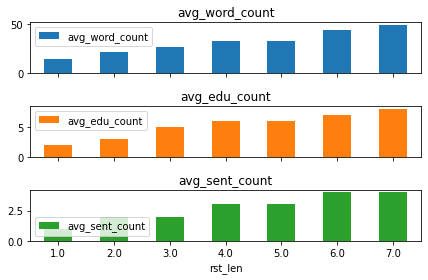

In [3]:
# load model and set up generation params
model_name="NLG_rt"
model_version = 15
max_input_len = 200
sample_count = 25
context_len=0

nlg_model = TrainingModule.load_nlgmodel(model_name=model_name ,model_version=model_version, max_input_len=max_input_len)

bad_words = ["<|rst|>","<|ta|>",r"\n" ] 
bad_words_ids = [nlg_model.nlg_tokenizer.e2m_tokenizer.encode(bad_word, add_prefix_space=False) for bad_word in bad_words]
bad_words_ids = [nlg_model.nlg_tokenizer.e2m_tokenizer.encode(bad_word, add_prefix_space=True) for bad_word in bad_words]
bad_words_ids = bad_words_ids + [[526], [55],[8172]]
generation_params = {'num_beams':1, 'temperature':1.2, 'repitition_penalty':2.0, 
                     'early_stopping':False, 'do_sample':False, 'no_repeat_ngram_size':3, 'bad_words_ids':bad_words_ids, 'max_length':200 } #,'min_length':4

# Creating directory for records
test_type= "a1_control_length"
test_type_version = '1'
_dir = f"./Evaluation/{test_type}/{test_type_version}/model_v{model_version}"
os.makedirs(_dir,exist_ok=True)

rst_lens = np.arange(1,8).tolist()
dict_rstlen_stats = {k:{} for k in rst_lens} #nested dicts to hold stats for each rst_len

df_stats = pd.DataFrame(columns=['rst_len','word_count', 'edu_count', 'sent_count']) #Pandas dataframe to store information on length of output text

# Gathering a set of topic/topic_scores to be re-used by each rst_len round of generations
li_datum = sampler.sample( 
    li_RST_len = [ int(sum(rst_lens)/len(rst_lens)) ],
    sample_count = sample_count
)

li_topic_textrank = [ datum[2] for datum in li_datum ]# list of (2 lists)

for rst_len  in rst_lens:

    li_RST_len = [ rst_len ]

    rst_variation= 'combinations'#independent


    # Gathering list of list of examples to use for evaluation
    # We iterate over each group of rst structures with length n
    # We save all the produced text for each group and then And produce statistics for each group
    li_datum = sampler.sample( 
        li_RST_len = li_RST_len,
        sample_count = sample_count
    )

    
    # calculate lengths of generated text
    for idx,datum in enumerate(li_datum):
        
        #region: unpacking datum
        utterance, li_rst, _ = datum
        rst_rels = [ _dict['rel'] for _dict in li_rst ]
        rst_ns = [ _dict['ns'] for _dict in li_rst ]
        rst_pos = [ _dict['pos'] for _dict in li_rst ]
        topics, topics_score = zip( *li_topic_textrank[idx] ) 
        

        # region: Creating prediction
            #Creating utterance_context
        start_utt = ' '.join(utterance.split(' ')[:context_len])

            # Creating encoded input
        encoded_input = nlg_model.nlg_tokenizer.encode_v2_exda(rst_rels, rst_ns, rst_pos ,
                                                    topics, topics_score, start_utt,
                                                    pad_utterance=False, generate_mode=True)

            # Add batch dimension to data
        for key in ['tnsr_rst_rels', 'tnsr_rst_ns', 'tnsr_rst_pos',
                    'tnsr_topics_phrase','tnsr_topics_score','tknzd_utt',
                    'position_ids','token_type_ids',
                        'attn_mask','rst_start_token']:
            encoded_input[key] = torch.unsqueeze( encoded_input[key],axis=0).cuda()


        # Generating model output, given original rst structure
        output = nlg_model.generate(encoded_input, **generation_params)
        decoded_text = nlg_model.nlg_tokenizer.e2m_tokenizer.decode(output[0],skip_special_tokens=True)
        
        word_count = len( decoded_text.split() )
        li_text_edu = parser_wrapper3.main( json_li_li_utterances= json.dumps([[decoded_text]]), skip_parsing=True,redirect_output=True)[0]
        edu_count = li_text_edu.count('EDU_BREAK')
        
        li_txt_sentseg = sent_detector.tokenize(decoded_text)
        sent_count = len(li_txt_sentseg)
        
        df_stats = df_stats.append( { 
                'rst_len':rst_len,
               'word_count': word_count,
                'edu_count': edu_count,
            'sent_count':sent_count
                
        }, ignore_index = True )

# Aggregating the length statistics
df_stats_agg = df_stats.astype(float).groupby('rst_len', as_index=False).agg(avg_word_count=('word_count','median'), 
                                            avg_edu_count= ('edu_count','median'),
                                            avg_sent_count=('sent_count','median'))

df_stats_agg.to_csv( os.path.join(_dir,"avg_lengths_per_rstlen.csv"), index=False ) 

df_stats_agg.to_csv( os.path.join(_dir,"avg_lengths_per_rstlen.csv"), index=False ) 
# Producing Tables showing distribution of lengths, saving to file
#for length_stat in ['word_count','edu_count','sent_count']:
axes = df_stats_agg.plot.bar(x='rst_len', rot=0, subplots=True)
axes[1].legend(loc=2)
axes[2].legend(loc=3)
axes[0].figure.tight_layout()
axes[0].figure.savefig(os.path.join(_dir, f"distribution_of_generated_text_len.png"), dpi=600, bbox_inches='tight')


del nlg_model

# A21) Use attention matrix to illustrate focus of attention in key examples
    

- Here we generate examples using the classes which our model models well: "Contrast","Temporal","Enablement","Comparison","Explanation", "Condition"
    - For each of these examples, we use an attention matric visualization to demonstrate how to attention works

In [ ]:
# load model and set up generation params
model_name="NLG_rt"
model_version = 15
max_input_len = 200
context_len=1

nlg_model = TrainingModule.load_nlgmodel(model_name=model_name ,model_version=model_version, max_input_len=max_input_len)

bad_words = ["<|rst|>","<|ta|>",r"\n" ] 
bad_words_ids = [nlg_model.nlg_tokenizer.e2m_tokenizer.encode(bad_word, add_prefix_space=False) for bad_word in bad_words]
bad_words_ids = [nlg_model.nlg_tokenizer.e2m_tokenizer.encode(bad_word, add_prefix_space=True) for bad_word in bad_words]
bad_words_ids = bad_words_ids + [[526], [55],[8172]]
generation_params = {'num_beams':1, 'temperature':1.2, 'repitition_penalty':2.0, 
                     'early_stopping':False, 'do_sample':False, 'no_repeat_ngram_size':3, 'bad_words_ids':bad_words_ids } #'max_length':30,'min_length':4
li_RST_len = [3]
rst_variation= 'combinations'#independent
test_type= "a21_illustrate_attention"
test_type_version=f"1"

dict_RSTrel_counts = {
     "Contrast":1,"Temporal":1,"Enablement":1,"Comparison":1,"Explanation":1, "Condition":1}

# Gathering list of examples to use for evaluation
li_datum = sampler.sample( 
    #li_subreddit= ["CasualConversation"],
    li_RST_len = li_RST_len,
    dict_RSTrel_counts = dict_RSTrel_counts
    
)


# Creating dataframe to record predictions 
_dir = f"./Evaluation/{test_type}/{test_type_version}/model_v{model_version}"
os.makedirs(_dir,exist_ok=True)
    
for idx,datum in enumerate(li_datum[:1]):
        
    #region: unpacking datum
    utterance, li_rst, topic_textrank = datum
    rst_rels = [ _dict['rel'] for _dict in li_rst ]
    rst_ns = [ _dict['ns'] for _dict in li_rst ]
    rst_pos = [ _dict['pos'] for _dict in li_rst ]
    topics, topics_score = zip( *topic_textrank ) 
         

    #Creating utterance_context
    start_utt = ' '.join(utterance.split(' ')[:context_len])
    
    # Creating encoded input
    encoded_input = nlg_model.nlg_tokenizer.encode_v2_exda(rst_rels, rst_ns, rst_pos ,
                                                topics, topics_score, start_utt,
                                                pad_utterance=False, generate_mode=True)
        
    # Add batch dimension to data and moving to GPU
    for key in ['tnsr_rst_rels', 'tnsr_rst_ns', 'tnsr_rst_pos',
                'tnsr_topics_phrase','tnsr_topics_score','tknzd_utt',
                'position_ids','token_type_ids',
                    'attn_mask','rst_start_token']:
        encoded_input[key] = torch.unsqueeze( encoded_input[key],axis=0).cuda()
    
    # Generating Text using our model
    output = nlg_model.generate(encoded_input, **generation_params)
    decoded_text = nlg_model.nlg_tokenizer.e2m_tokenizer.decode(output[0],skip_special_tokens=False)    
    
    
    # Retreiving attention matrix for the text that our model just generating by passing generated_text through, with the relevant encoding
    encoded_input2 = nlg_model.nlg_tokenizer.encode_v2_exda(rst_rels, rst_ns, rst_pos ,
                                                topics, topics_score, decoded_text,
                                                pad_utterance=False, generate_mode=False)
    
    # Add batch dimension to data and moving to GPU
    for key in ['tnsr_rst_rels', 'tnsr_rst_ns', 'tnsr_rst_pos',
                'tnsr_topics_phrase','tnsr_topics_score','tknzd_utt',
                'position_ids','token_type_ids',
                    'attn_mask','rst_start_token']:
        encoded_input2[key] = torch.unsqueeze( encoded_input2[key],axis=0).cuda()

    encoded_input2 = nlg_model.forward_embedding(encoded_input2)

    outputs = nlg_model.transformer.transformer.forward( input_embeds=encoded_input2['input_embeds'],
                                attention_mask = encoded_input2['attn_mask'],
                                position_embeds = encoded_input2['position_embeds'],
                                token_type_ids = None, #token type embedding new (This gpt implementation incorrectly uses same embedding layer as for input)
                                                        # Further we handle token_type embedding in forward_embedding layer
                                output_attentions=True,
                                return_dict=True)
    attention_matrices = outputs['all_self_attentions']
    
    # Creating visualizations from attention matrix
        
        #Getting ids which are input to model
    rst_start_ids = encoded_input2['rst_start_token'].tolist()[0]
    rst_rels_ids = encoded_input2['tnsr_rst_rels'].tolist()[0] #Maybe Convert these to their rst word representations
    topics_ids = encoded_input2['tnsr_topics_phrase'].tolist()[0]
    utterance_ids = encoded_input2['tknzd_utt'].tolist()[0]
        
        #Getting tokens
    rst_start_tokens = nlg_model.nlg_tokenizer.e2m_tokenizer.convert_ids_to_tokens(rst_start_ids)
    rst_rels_tokens = [ nlg_model.nlg_tokenizer.rst_rel_labeler.inverse_transform([id_])[0] if id_<=18 else "<|PAD|>" for id_ in rst_rels_ids ]
    topic_tokens = nlg_model.nlg_tokenizer.e2m_tokenizer.convert_ids_to_tokens(topics_ids)
    utterance_tokens = nlg_model.nlg_tokenizer.e2m_tokenizer.convert_ids_to_tokens(utterance_ids)
    
    tokens = rst_start_tokens + rst_rels_tokens + topic_tokens + utterance_tokens
    
        #Finding position of <|PAD|> AND <|endoftext|> tokens and removing them and removing their positions from the token list and the attention_matrics
    #pos_to_remove =  [i for i, j in enumerate(tokens) if j in ['<|PAD|>','<|endoftext|>'] and i!= len(rst_start_ids)+len(rst_rels_ids)+len(topics_ids) ]
    
    pos_to_remove =  [i for i, j in enumerate(tokens) if j in ['<|PAD|>','<|endoftext|>'] and i!= len(rst_start_ids)+len(rst_rels_ids)+len(topics_ids) ]
    pos_to_remove = pos_to_remove + list(range(3, len(rst_start_ids)+len(rst_rels_ids)+len(topics_ids)))
    pos_to_remove = pos_to_remove + [0]
    pos_to_remove = sorted(pos_to_remove)
    pos_to_remove = list(set(pos_to_remove))
    pos_to_remove.reverse()
            
            #removign from token list
    for pos in pos_to_remove:
        tokens.pop(pos)
            
            #removing from attention matrices
    new_attention_matrices = tuple()
    for idx in range(len(attention_matrices)):
        _ = np.delete(attention_matrices[idx].cpu(), pos_to_remove, axis=2)
        _ = np.delete(_, pos_to_remove, axis=3)
        new_attention_matrices = new_attention_matrices + (_,)
        
    
        #dynamic visualization method
    head_view(new_attention_matrices, tokens)
        
        #static visualisation method
            #Decide which tokens/words will be included in attention plot
            #Select the rows of attention that show attention to the rst_tokens of interest
            #Crop the attention matrices to remove the Masked tokens and other tokens in context
            #Print the attention from each head seperately
    

    # Creating dictionary with info related to generated output
    generated_info = {'rst_relations':rst_rels, 'utterance': [decoded_text], 'topics':topics, 'topics_score':topics_score }
    
    # Saving info to file
    fn_base = f'example_{str(idx).zfill(4)}'
    json.dump(generated_info, open( os.path.join( _dir, f"{fn_base}_info.csv"), "w" ))
    

del nlg_model

# C) Evaluate how well RST structure of generated text aligns to rst structure identified by original model
  

  - We randomly sample rst structures of length [2] #test for all three
  - For each rst relation we:
    - Sample 200 datums that include the relation:
   
   - save the dataset to pickle
   
   - For each datum we generate an output utterance with our model
        - Experiment with removing the prompt
        
        
    - RST parse each genrated text
    
    - Metric 1: Whether or not the relation, is included in the RST parsing for gen text. Must be captured the exact same number of times
        This should produce a recall figure for each relation
    
    - Metric 2: Whether or not the relation and position, is included in the RST parsing
        This should produce a recall figure for each relation
    
    - Metric 3: Confusion matrix showing the relation predicted instead of the true one. At specific position
        Same as metric 2, but also use a confusion matrix torch metric to track. then produce plot
    

In [4]:
#helper functions
import nltk
from utils_nlg import tree_order

def parse_tree_from_string(str_tree):
#     li_subtrees = []
#     for idx, pt_str in enumerate(str_tree):
    try:
        if str_tree == '': raise ValueError
        parsed_tree = nltk.tree.Tree.fromstring(str_tree, brackets="{}")
    except ValueError:
        parsed_tree = None
        pass
    
    return parsed_tree

def _tree_to_rst_code(_tree):
    """Converst RST Tree to rst code used in NLG model

        Args:
            method (int, optional): [description]. Defaults to 1.
        
        Return:
            if method==0:
                Three lists zipped together
                List 1 Represents A Flattened version of the rst relations in the RST tree
                List 2 the nuclearity/satellite couple type e.g. N-N or NS
                List 3 The position in a binary tree of max depth 5

                #TODO: possibly figure out some way to normalize this vector
    """

    # Getting List 1 and 2
    li_rels_ns = []
    
    for depth in range( _tree.height(),1,-1 ):
        
        # sublist of rst relation and nuclearity tag
        subli_rels_ns = [  re.findall(r'[a-zA-Z\-]+' ,sub_tree._label)  for sub_tree in _tree.subtrees() if sub_tree.height()==depth  ]
        subli_rels_ns = [ [ _li[0], ''.join(_li[1:]).lstrip('unit') ] for _li in subli_rels_ns ]

        li_rels_ns.extend(subli_rels_ns)

    # Getting List 3
        #getting position of all non leave
    tree_pos = _tree.treepositions()
    leaves_pos = _tree.treepositions('leaves')
    pos_xleaves = list(set(tree_pos) - set(leaves_pos)) #unordered
    pos_xleaves = [  tuple(x if x<2 else 1 for x in _tuple ) for _tuple in pos_xleaves]        #binarizing ( correcting any number above 1 to 1)
        # reording pos_xleaves to breadfirst ordering
    li_bintreepos = sorted([ tree_order.get(x,-1) for x in pos_xleaves])

    # Zipping List 1 2 and 3
    li_dict_rels_ns_bintreepos = [  {'rel':rels_ns[0], 'ns':rels_ns[1], 'pos': bintreepos } for rels_ns,bintreepos in zip(li_rels_ns,li_bintreepos) if bintreepos!=-1 ]

    return li_dict_rels_ns_bintreepos

def capitalize(text):
    punc_filter = re.compile('([.!?;]\s+)')
    
    split_with_punctuation = punc_filter.split(text)
    
    #print(split_with_punctuation)
    
    for i,j in enumerate(split_with_punctuation):
        if len(j) > 0:
        #if True:
            split_with_punctuation[i] = j[0].upper()
            if len(j) > 1:
                split_with_punctuation[i] += j[1:]
            
    text = ''.join(split_with_punctuation)
    return text

/home/akann1w0w1ck/mastering-conversation/rl_conv/pretrain/NLG/train_nlg.py:2509: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  scores_dict = yaml.load( open(checkpoint_yaml_file,"r") ) #key= ckptpath, value = val_loss




 Operating on li_RST_len:[3]
Dataset does exist, restoring from saved path

 Metrics have not been calculated: Generating metrics now
	 Generating metrics for relation: Attribution
	 Generating metrics for relation: Background
	 Generating metrics for relation: Cause
	 Generating metrics for relation: Comparison
	 Generating metrics for relation: Condition
	 Generating metrics for relation: Contrast
	 Generating metrics for relation: Elaboration
	 Generating metrics for relation: Enablement
	 Generating metrics for relation: Evaluation
	 Generating metrics for relation: Explanation
	 Generating metrics for relation: Joint
	 Generating metrics for relation: Manner-Means
	 Generating metrics for relation: Topic-Comment
	 Generating metrics for relation: Summary
	 Generating metrics for relation: Temporal
	 Generating metrics for relation: Topic-Change
	 Generating metrics for relation: n
	 Generating metrics for relation: same-unit


Traceback (most recent call last):
  File "../DockerImages/feng_hirst_rst_parser/src/parse2.py", line 182, in parse
    pt = self.treebuilder.build_tree(doc)
  File "../DockerImages/feng_hirst_rst_parser/src/treebuilder/build_tree_CRF.py", line 100, in build_tree
    self.multi_parser.parse_document(doc)
  File "../DockerImages/feng_hirst_rst_parser/src/parsers/multi_sentential_parser.py", line 32, in parse_document
    return self.parse_sequence(doc)
  File "../DockerImages/feng_hirst_rst_parser/src/parsers/multi_sentential_parser.py", line 59, in parse_sequence
    doc.discourse_tree = doc.constituents[0].parse_subtree
IndexError: list index out of range


	 Generating metrics for relation: textual-organization


/home/akann1w0w1ck/virtual_envs/py38_mconv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/akann1w0w1ck/virtual_envs/py38_mconv/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Creating Confusion matrix: Normalized Confusion matrix: Normalized, Recall, rec_prec: recall
Creating Confusion matrix: Normalized Confusion matrix: Normalized, Precision, rec_prec: precision


 Operating on li_RST_len:[4]
Dataset does not exist, creating now
Generating Data for rst relation: Attribution
Generating Data for rst relation: Background
Generating Data for rst relation: Cause
Generating Data for rst relation: Comparison
Generating Data for rst relation: Condition
Generating Data for rst relation: Contrast
Generating Data for rst relation: Elaboration
Generating Data for rst relation: Enablement
Generating Data for rst relation: Evaluation
Generating Data for rst relation: Explanation
Generating Data for rst relation: Joint
Generating Data for rst relation: Manner-Means
Generating Data for rst relation: Topic-Comment
Generating Data for rst relation: Summary
Generating Data for rst relation: Temporal
Generating Data for rst relation: Topic-Change
Generating Data for rst rela

/home/akann1w0w1ck/virtual_envs/py38_mconv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/akann1w0w1ck/virtual_envs/py38_mconv/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Creating Confusion matrix: Normalized Confusion matrix: Normalized, Recall, rec_prec: recall
Creating Confusion matrix: Normalized Confusion matrix: Normalized, Precision, rec_prec: precision


 Operating on li_RST_len:[6]
Dataset does not exist, creating now
Generating Data for rst relation: Attribution
Generating Data for rst relation: Background
Generating Data for rst relation: Cause
Generating Data for rst relation: Comparison
Generating Data for rst relation: Condition
Generating Data for rst relation: Contrast
Generating Data for rst relation: Elaboration
Generating Data for rst relation: Enablement
Generating Data for rst relation: Evaluation
Generating Data for rst relation: Explanation
Generating Data for rst relation: Joint
Generating Data for rst relation: Manner-Means
Generating Data for rst relation: Topic-Comment
Generating Data for rst relation: Summary
Generating Data for rst relation: Temporal
Generating Data for rst relation: Topic-Change
Generating Data for rst rela

Traceback (most recent call last):
  File "../DockerImages/feng_hirst_rst_parser/src/parse2.py", line 182, in parse
    pt = self.treebuilder.build_tree(doc)
  File "../DockerImages/feng_hirst_rst_parser/src/treebuilder/build_tree_CRF.py", line 100, in build_tree
    self.multi_parser.parse_document(doc)
  File "../DockerImages/feng_hirst_rst_parser/src/parsers/multi_sentential_parser.py", line 32, in parse_document
    return self.parse_sequence(doc)
  File "../DockerImages/feng_hirst_rst_parser/src/parsers/multi_sentential_parser.py", line 59, in parse_sequence
    doc.discourse_tree = doc.constituents[0].parse_subtree
IndexError: list index out of range


	 Generating metrics for relation: Contrast
	 Generating metrics for relation: Elaboration
	 Generating metrics for relation: Enablement


Traceback (most recent call last):
  File "../DockerImages/feng_hirst_rst_parser/src/parse2.py", line 182, in parse
    pt = self.treebuilder.build_tree(doc)
  File "../DockerImages/feng_hirst_rst_parser/src/treebuilder/build_tree_CRF.py", line 100, in build_tree
    self.multi_parser.parse_document(doc)
  File "../DockerImages/feng_hirst_rst_parser/src/parsers/multi_sentential_parser.py", line 32, in parse_document
    return self.parse_sequence(doc)
  File "../DockerImages/feng_hirst_rst_parser/src/parsers/multi_sentential_parser.py", line 59, in parse_sequence
    doc.discourse_tree = doc.constituents[0].parse_subtree
IndexError: list index out of range


	 Generating metrics for relation: Evaluation
	 Generating metrics for relation: Explanation
	 Generating metrics for relation: Joint
	 Generating metrics for relation: Manner-Means
	 Generating metrics for relation: Topic-Comment
	 Generating metrics for relation: Summary
	 Generating metrics for relation: Temporal
	 Generating metrics for relation: Topic-Change
	 Generating metrics for relation: n
	 Generating metrics for relation: same-unit
	 Generating metrics for relation: textual-organization


/home/akann1w0w1ck/virtual_envs/py38_mconv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/akann1w0w1ck/virtual_envs/py38_mconv/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Creating Confusion matrix: Normalized Confusion matrix: Normalized, Recall, rec_prec: recall
Creating Confusion matrix: Normalized Confusion matrix: Normalized, Precision, rec_prec: precision


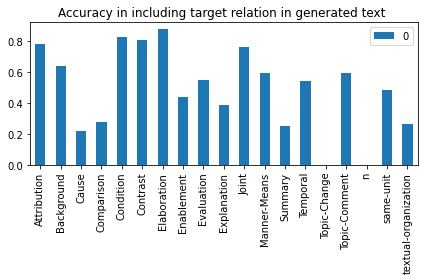

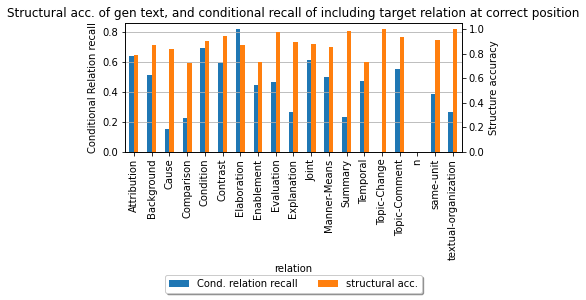

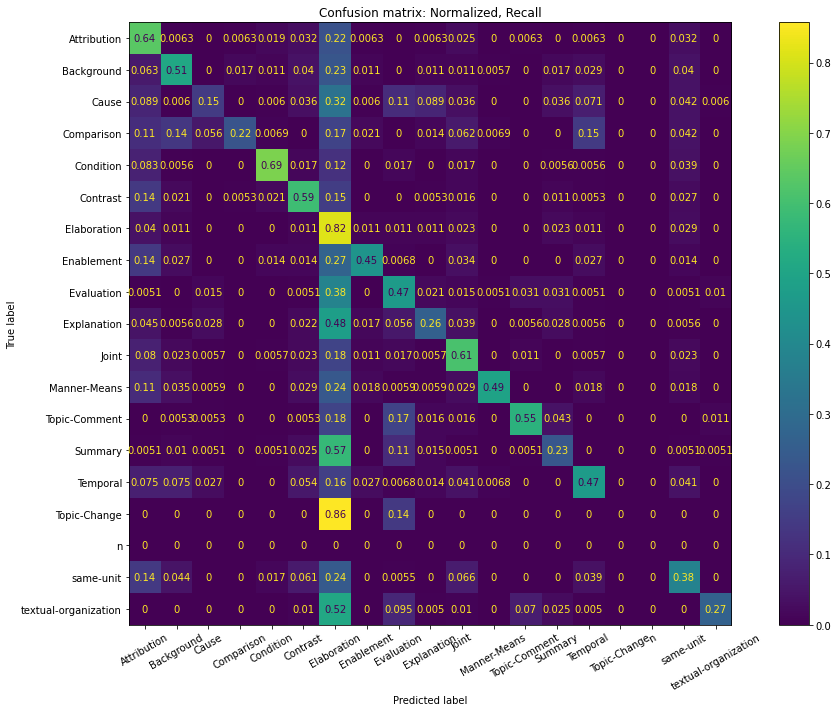

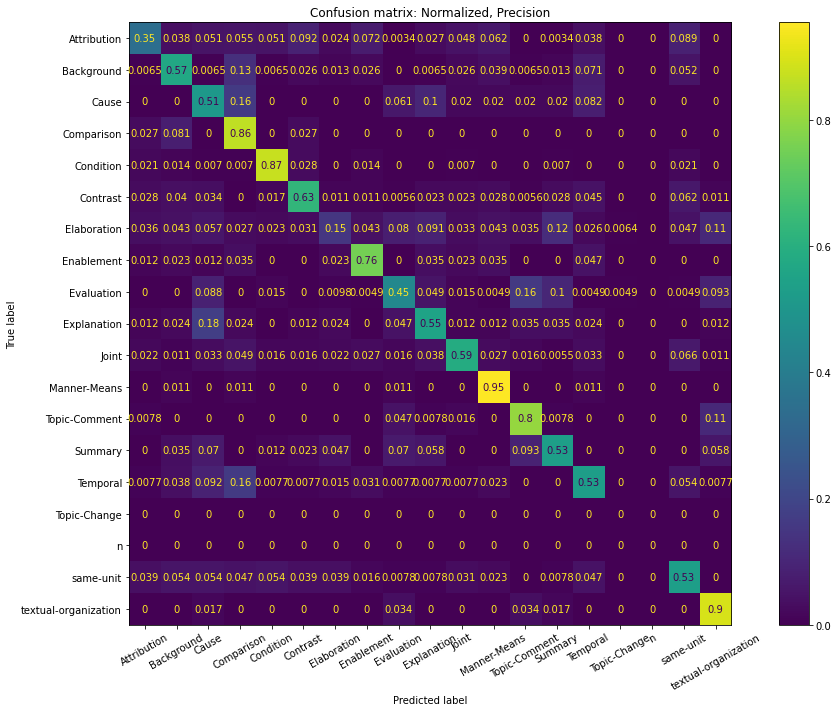

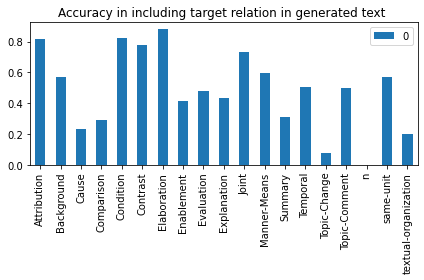

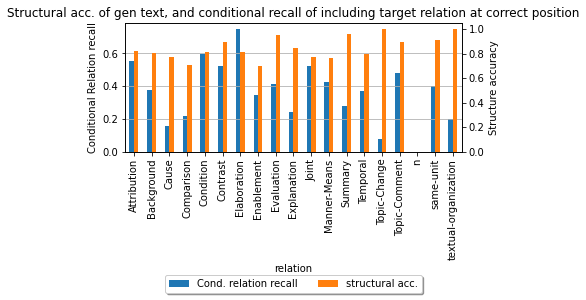

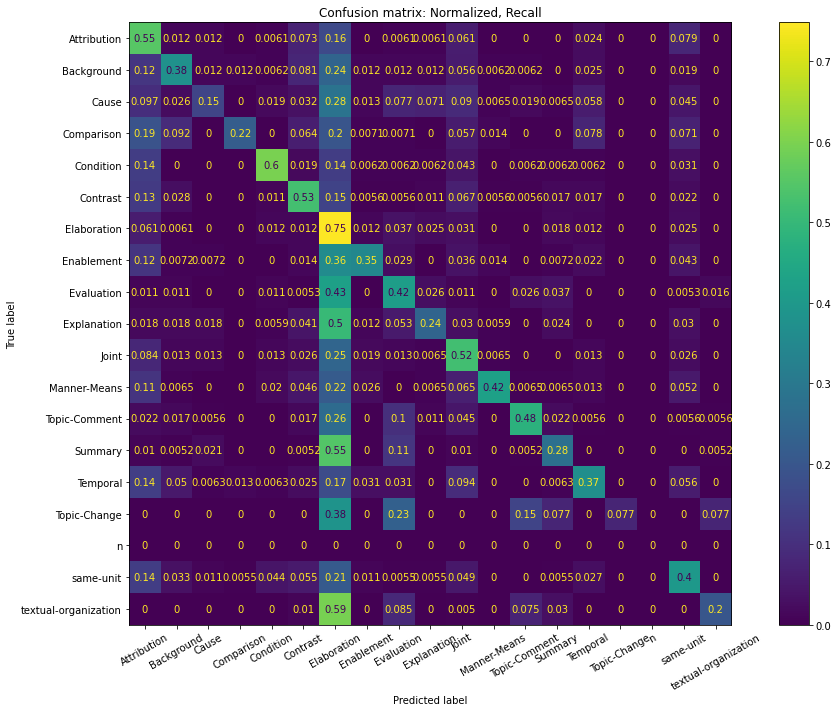

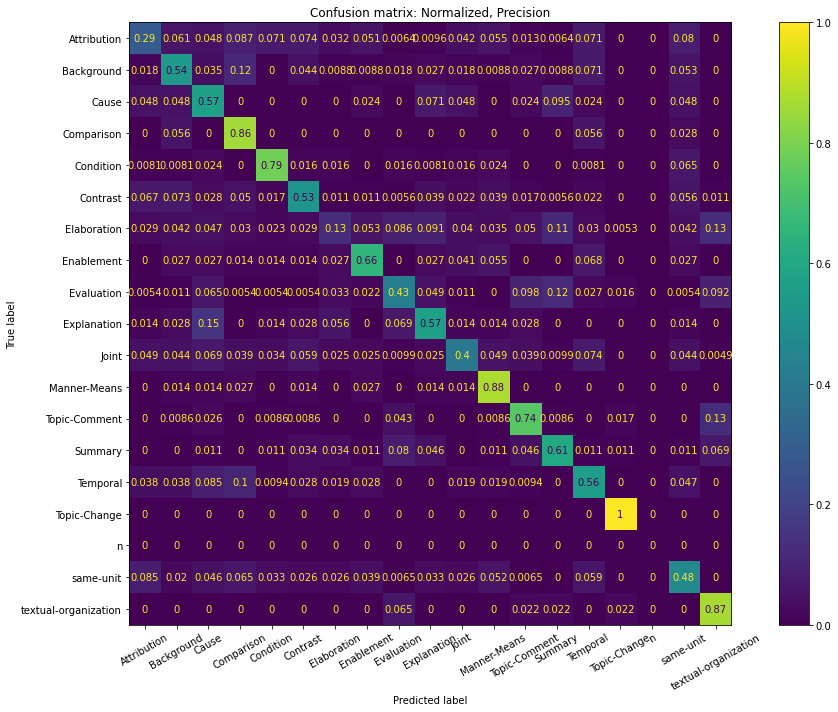

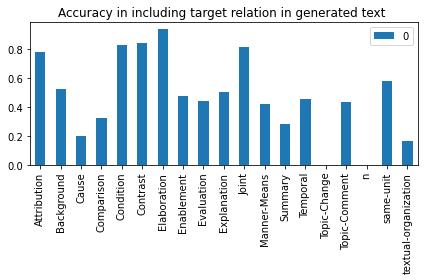

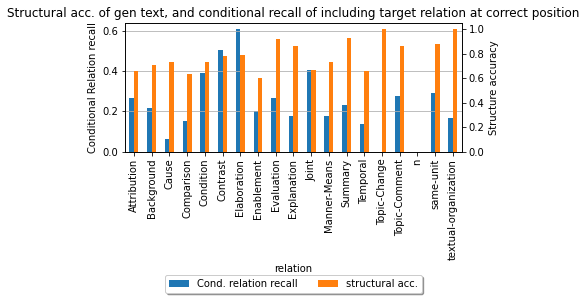

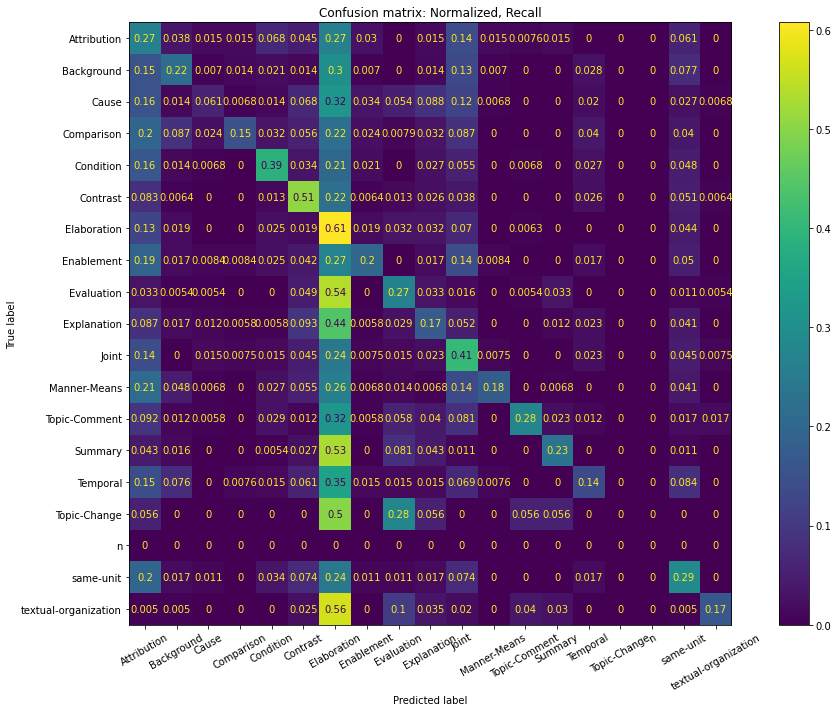

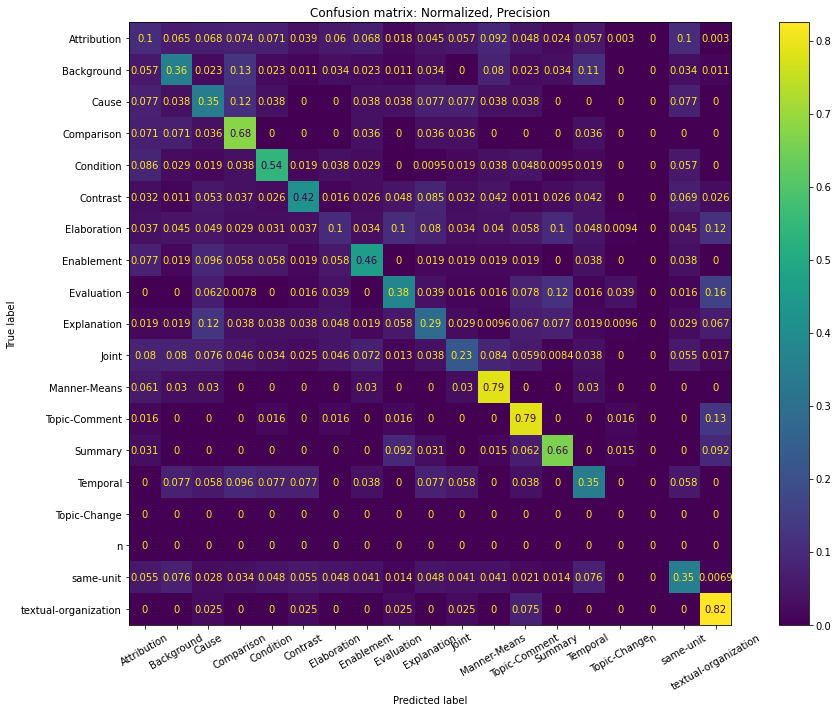

In [5]:
#setting GPU to use
torch.cuda.set_device(0) 

#data filtering variables
sample_count = 200
li_subreddit = []
#li_li_RST_len = [ [1], [2], [3], [4] ] # [5], [6], [8], [10] , [12], [14] ] 
li_li_RST_len = [ [3], [4], [6] ]
#li_RST_len = [ 2 ]

prompt_len = 3 #prompt performs better than no prompt

rst_variation= 'combinations'#independent

li_relations_names = ['Attribution',
                'Background','Cause','Comparison','Condition',
                'Contrast','Elaboration','Enablement','Evaluation',
                'Explanation','Joint','Manner-Means','Topic-Comment',
                'Summary','Temporal','Topic-Change','n','same-unit','textual-organization']

# load model and set up generation params

    #NLG model variables
model_version = 16
model_name = 'NLG_rt'
model_params={'model_version':model_version }
model, tokenizer = load_model(model_name, **model_params) 

        
    #generation params
bad_words = ["<|rst|>","<|ta|>",r"\n", "\s"," \s", ". \s" ] 
bad_words_ids = [model.nlg_tokenizer.e2m_tokenizer.encode(bad_word, add_prefix_space=False) for bad_word in bad_words]
bad_words_ids = [model.nlg_tokenizer.e2m_tokenizer.encode(bad_word, add_prefix_space=True) for bad_word in bad_words]
bad_words_ids = bad_words_ids + [[526], [55],[8172]]

generation_params = {'num_beams':1, 'temperature':1.2, 'repitition_penalty':2.0, 
                     'early_stopping':True, 'do_sample':False, 'no_repeat_ngram_size':3, 'bad_words_ids':bad_words_ids, 'max_length':300 } #,'min_length':4


# We explore how well our model performs at different RST encoding lengths
for li_RST_len in li_li_RST_len:
    print(f"\n\n Operating on li_RST_len:{li_RST_len}")
    
    # Creating directory for records
    test_type= "c_alignment_to_true_RST"
    test_version = f"{str(li_RST_len[0])}"
    _dir = f"./Evaluation/{test_type}/RST_len_{test_version}"
    os.makedirs(_dir,exist_ok=True)
    
    #Creating record of test details
    test_info = {'sample_count_per_relation':sample_count, 'subreddits':li_subreddit, 
                    'RST code lengths':li_RST_len, 'RST relations to eval':li_relations_names,
                    'prompt_len':prompt_len, 'model_version':model_version,
                    'gen_params':generation_params }

    json.dump(test_info, open(os.path.join(_dir, "test_info.json"), "w"))


    # Loading proc Dataset or Restoring it if it already exists
    dict_relation_samples_fp = os.path.join(_dir,"dict_relation_samples.pickle") #{'rst_relation': dict } dict={'li_rst_rels':[], 'li_rst_ns':[], 'li_rst_pos':[] ..}
    dset_exists = os.path.exists(dict_relation_samples_fp)

    if dset_exists == True:
        print("Dataset does exist, restoring from saved path")
        dict_relation_samples = pickle.load(open(dict_relation_samples_fp,"rb"))

    if dset_exists == False:

        print("Dataset does not exist, creating now")
        dict_relation_samples = {}

        # Gathering N samples for each relation
        for relation in li_relations_names:

            print(f"Generating Data for rst relation: {relation}")
            # Gathering list of list of examples to use for evaluation
            # We iterate over each group of rst structures with length n
            # We save all the produced text for each group and then And produce statistics for each group        

            li_datum = sampler.sample( li_subreddit = li_subreddit,
                                        li_RST_len = li_RST_len,
                                        dict_RSTrel_counts = {relation:1},
                                        sample_count = sample_count,
                                            rst_rel_count_mode='equal_to')

            # Storing a list of the Utterances that we use
            dset = {}
            dset['li_rst_rels'] = []
            dset['li_rst_ns'] = []
            dset['li_rst_pos'] = []

            dset['li_topics'] = []
            dset['li_topics_score'] = []

            dset['li_utterance'] = []


            # calculate lengths of generated text
            for idx,datum in enumerate(li_datum):

                # region: unpacking datum:
                utterance, li_rst, topic_textrank = datum
                rst_rels = [ _dict['rel'] for _dict in li_rst ]
                rst_ns = [ _dict['ns'] for _dict in li_rst ]
                rst_pos = [ _dict['pos'] for _dict in li_rst ]
                topics, topics_score = zip( *topic_textrank ) 

                    # Appending to fully processed dataset
                dset['li_rst_rels'].append(rst_rels)
                dset['li_rst_ns'].append(rst_ns)
                dset['li_rst_pos'].append(rst_pos)

                dset['li_topics'].append(topics)
                dset['li_topics_score'].append(topics_score)

                dset['li_utterance'].append(utterance)

            dict_relation_samples[relation] = dset

        # Saving data
        pickle.dump(dict_relation_samples, open( dict_relation_samples_fp ,"wb") )

    # Loading metrics if they exist, otherwise calculating them
    metrics_records_fp = os.path.join(_dir,"metrics_records.pickle")
    metric_exists = os.path.exists(metrics_records_fp)

    if metric_exists == False:
        print("\n Metrics have not been calculated: Generating metrics now")
        metric1 = { k:[] for k in li_relations_names} # keys=relations, values=list of 1s and 0s
        metric23_correct_structure = { k:[] for k in li_relations_names} # keys=relations, values=list of 1s and 0s, indicating if gen text had a node at position n, where n is the position of relation in origin text
        metric2 = { k:[] for k in li_relations_names} # keys=relations, values=list of 1s and 0s
        metric3 = { k:[] for k in li_relations_names} # keys=rleations, values= list of relations(strings)


        # Evaluating Each Relation
        for relation in li_relations_names:
            print(f"\t Generating metrics for relation: {relation}")

            rel_sample_size = len(dict_relation_samples[relation]['li_rst_rels'])
            for idx in range(rel_sample_size):

                # unpacking data
                rst_rels = dict_relation_samples[relation]['li_rst_rels'][idx]
                rst_ns = dict_relation_samples[relation]['li_rst_ns'][idx]
                rst_pos = dict_relation_samples[relation]['li_rst_pos'][idx]

                topics = dict_relation_samples[relation]['li_topics'][idx]
                topics_score = dict_relation_samples[relation]['li_topics_score'][idx]

                utterance = dict_relation_samples[relation]['li_utterance'][idx]

                # region: generating text given context and possibly (prompt)
                    #Creating prompt
                prompt = ' '.join(capitalize(utterance).split(' ')[:prompt_len])

                gen_text = model.get_predicted_utterance(rst_rels, rst_ns, rst_pos ,
                                                            topics, topics_score, prompt,
                                                        generation_params)

                # region: Parsing text using RST parser
                try:
                    str_tree = parser_wrapper3.main( json_li_li_utterances= json.dumps([[capitalize(gen_text)]]), skip_parsing=False, redirect_output=True)[0][0]
                except Exception as e:
                    continue

                parsed_tree = parse_tree_from_string(str_tree)
                li_parsedrst_dict = _tree_to_rst_code(parsed_tree) #rst format

                #calclating metrics

                    #metric 1 - Checking if rst parsing for generated text has the target relation in it
                bool_metric1 = any( relation==parsed_relation for parsed_relation in [ dict_['rel'] for dict_ in li_parsedrst_dict  ] )
                metric1[relation].append(bool_metric1)

                    #metric 2 - Checking if rst parsed for generated text has the target relation in it, but also at the correct position
                    #metric 3 - Investigating what relation was predicted at the specific position of the relation we aim to investigate

                            # These metrics are conditional on the same structure being predicted: that gen text has a node at position n, where n is the position of rel in the true text
                true_node_position_of_rel = rst_pos[ rst_rels.index(relation) ]

                gen_node_at_true_pos = [dict_ for dict_ in li_parsedrst_dict if dict_['pos']==true_node_position_of_rel ] 

                if len(gen_node_at_true_pos) == 0:
                    # gen text has different structure to reference text: no node at posiiton n
                    metric23_correct_structure[relation].append(0)

                else:
                    metric23_correct_structure[relation].append(1)

                    gen_relation_at_true_pos = gen_node_at_true_pos[0]['rel']
                    metric3[relation].append(gen_relation_at_true_pos)

                    correct_relation_at_true_pos = gen_relation_at_true_pos == relation
                    metric2[relation].append(correct_relation_at_true_pos)

        #saving metrics
        metrics_records = {'metric1':metric1,
                          'metric2':metric2,
                          'metric3':metric3,
                          'metric23':metric23_correct_structure}

        pickle.dump(metrics_records, open(metrics_records_fp,"wb"))
        del metrics_records

    elif metric_exists == True:
        print("Metrics have been calculated, restoring from file")
        metrics_records = pickle.load(open(metrics_records_fp,"rb"))

        metric1 = metrics_records['metric1']
        metric23_correct_structure = metrics_records['metric23']
        metric2 = metrics_records['metric2']
        metric3 = metrics_records['metric3']


    # freeing memory        
        del model
        torch.cuda.empty_cache()

    # Creating Tables and Illustrations

        # aggregating metrics
    metric1_agg = {}
    metric23_correct_structure_agg = {}
    metric2_agg = {}
    metric3_agg = {'preds':[], 'truth':[]} #combining the lists of lists into one list for preds, and creating a truth list
    for rel in metric1.keys():
        metric1_agg[rel] = float(np.mean(metric1[rel]))
        metric23_correct_structure_agg[rel] = float(np.mean(metric23_correct_structure[rel]))
        metric2_agg[rel] = float(np.mean(metric2[rel]))

        metric3_agg['preds'].extend( metric3[rel] )
        metric3_agg['truth'].extend( [rel]*len(metric3[rel]) )

        #metric 1 - Whether or not the relation, is included in the RST parsing for gen text. 
    df_metric1_agg = pd.DataFrame.from_dict( metric1_agg, orient='index' )
    df_metric1_agg = df_metric1_agg.sort_index()
    df_metric1_agg.to_csv(os.path.join(_dir, f"metric1_table.csv"))

            #bar plot
    ax_metric1 =  df_metric1_agg.plot.bar()
    ax_metric1.set_title('Accuracy in including target relation in generated text ')
    ax_metric1.figure.tight_layout()
    ax_metric1.figure.savefig(os.path.join(_dir, f"metric1_barplot.png"), dpi=600, bbox_inches='tight')

    #del metric1_agg, df_metric1_agg, metric1

        #metric 2 - Whether or not the relation and position, is included in the RST parsing
            #saving csv record
    df_metric2_agg = pd.DataFrame.from_dict( metric2_agg, orient='index' )
    df_metric2_agg.columns = ['Cond. relation recall']

    df_metric23_agg = pd.DataFrame.from_dict( metric23_correct_structure_agg, orient='index' )
    df_metric23_agg.columns = ['structural acc.']

    df_metric2_agg = df_metric2_agg.join(df_metric23_agg, how='inner', sort=True)

    df_metric2_agg.to_csv(os.path.join(_dir, f"metric2_table.csv"))
        #barplot
    #ax1_metric2, ax2_metric2
    ax_metric2 = df_metric2_agg.plot.bar(secondary_y='structural acc.',legend=None)

    ax_metric2.figure.legend(loc='upper center', bbox_to_anchor=(0.5, 0.05),
              ncol=2, fancybox=True, shadow=True)

    ax_metric2.set_title('Structural acc. of gen text, and conditional recall of including target relation at correct position')

    ax_metric2.set_xlabel('relation')

    ax_metric2.set_ylabel('Conditional Relation recall')
    ax_metric2.right_ax.set_ylabel('Structure accuracy')

    ax_metric2.grid(b=True, which='major', axis='y')

    ax_metric2.figure.tight_layout()
    ax_metric2.figure.savefig(os.path.join(_dir, f"metric2_barplot.png"), dpi=600, bbox_inches='tight')

    # del df_metric2_agg, metric2_agg, metric2

        #metric 3 - Confusion matrix of which relation predictions,
            # with and without normalization

    np.set_printoptions(precision=2)
    titles_options = [
                        #("Confusion matrix: Not Normalized", None, ""),
                    ("Confusion matrix: Normalized, Recall", 'true', "recall"),
                      ("Confusion matrix: Normalized, Precision", 'true',"precision")]

    for title, normalize,rec_prec in titles_options:
        print(f"Creating Confusion matrix: Normalized {title}, rec_prec: {rec_prec}")

        fig, ax = pl.subplots(figsize=(14, 10))

        if rec_prec == "recall":
            reference = metric3_agg['truth']
            preds = metric3_agg['preds']

        elif rec_prec == "precision":
            preds = metric3_agg['truth']
            reference = metric3_agg['preds']

        cm = skl.metrics.confusion_matrix( reference,
                                          preds,
                                         labels=li_relations_names,
                                         normalize=normalize)

        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                      display_labels=li_relations_names)

        # NOTE: Fill all variables here with default values of the plot_confusion_matrix
        disp = disp.plot(include_values=True,
                         cmap='viridis', ax=ax, xticks_rotation=30.0, )

        disp.ax_.set_title(title)
        disp.ax_.figure.tight_layout()

        disp.ax_.figure.savefig(os.path.join(_dir, f"metric3_confusionmatrix_{'normalized' if normalize else 'not_normalized'}_{rec_prec}.png"), dpi=600, bbox_inches='tight')
    
#plt.show()

In [184]:
#TODO: convert this all to a method in my model

#input
rst_rels = ['Contrast','Temporal']
rst_ns = ['NS','NS']
rst_pos = [0,1]
topics = ('Bitcoin','a new watch')
topics_score = (1.20, 1.501)
prompt = ""

    # Generating Text
model.get_predicted_utterance( rst_rels, rst_ns, rst_pos, topics, topics_score, prompt, generation_params)


"I was like, before you, before I, before me, before the, before, before. But now, I am like, after me, after you, after the, after, before and after, after. _"


# E1) Coherence Test


        - use coherence test from here https://arxiv.org/pdf/1909.10705.pdf
        - Except Adapt it to re-order text based on DiscourseUnits
        - Use Data from any \r changemyview , just ensure that RST Tree length is between 2 and 32 long.
        - Baseline: GPT-2 (fine-tuned on your subreddit data), CTRL (with subreddit prompt),

## helper functions

In [6]:
# helper functions
def split(sequence, sep):
    chunk = []
    for val in sequence:
        if val == sep:
            yield chunk
            chunk = []
        else:
            chunk.append(val)
    yield chunk

def load_model(model_name, **kwargs ):
    
    if model_name == "NLG_rt":
        model = TrainingModule.load_nlgmodel(model_name=model_name,
                                             model_version=kwargs.get('model_version'), max_input_len=kwargs.get('max_input_len')).cuda()
        tokenizer = None
        
    elif model_name == "gpt2":
        dir_transformer = os.path.join("./models",model_name)
        dir_tokenizer = dir_transformer + "_tknzr"
        
        exists = os.path.isdir(dir_transformer)
        
        if exists == False:    
            model = GPT2LMHeadModel.from_pretrained(model_name).cuda()
            tokenizer = GPT2Tokenizer.from_pretrained(model_name)
            
            os.makedirs(dir_tokenizer, exist_ok=True)
            os.makedirs(dir_transformer, exist_ok=True)
            
            model.save_pretrained(dir_transformer)
            tokenizer.save_pretrained(dir_tokenizer)
        else:
            model = GPT2LMHeadModel.from_pretrained(dir_transformer).cuda()
            if os.path.isdir(dir_tokenizer):
                tokenizer = GPT2Tokenizer.from_pretrained(dir_tokenizer)
            else:
                tokenizer = GPT2Tokenizer.from_pretrained(dir_transformer)
            
    elif model_name == "ctrl":
        dir_transformer = os.path.join("./models",model_name.replace("/","_"))
        dir_tokenizer = dir_transformer + "_tknzr"
        exists = os.path.isdir(dir_transformer) 
        
        if exists == False:    
            model = CTRLLMHeadModel.from_pretrained(model_name).cuda()
            tokenizer = CTRLTokenizer.from_pretrained(model_name)
            
            os.makedirs(dir_tokenizer, exist_ok=True)
            os.makedirs(dir_transformer, exist_ok=True)
            
            model.save_pretrained(dir_transformer)
            tokenizer.save_pretrained(dir_tokenizer)
        else:
            model = CTRLLMHeadModel.from_pretrained(dir_transformer).cuda()
            tokenizer = CTRLTokenizer.from_pretrained(dir_tokenizer)
    
    else:
        raise Exception("not exist")
    return model, tokenizer

## actual code

Loading NLG_rt model 



/home/akann1w0w1ck/mastering-conversation/rl_conv/pretrain/NLG/train_nlg.py:2406: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  scores_dict = yaml.load( open(checkpoint_yaml_file,"r") ) #key= ckptpath, value = val_loss


Loading gpt2 model 

Loading ctrl model 

Dataset does exist, restoring from saved path
  model_name  ranking_score  ranking_error
0     NLG_rt       0.985333       1.466667
1       ctrl       0.994667       0.533333
2       gpt2       0.977333       2.266667


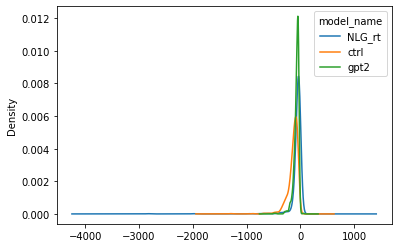

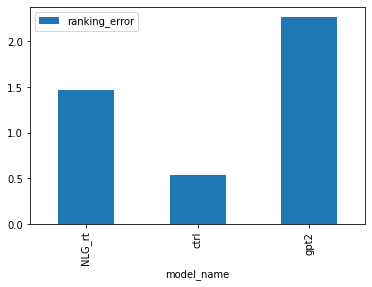

In [18]:
#setting GPU to use

torch.cuda.set_device(0) 

#RST filtering variables
#sample_count = 500
sample_count = 750
li_subreddit= ["WritingPrompts_title_only"]
#li_subreddit=["changemyview"]#"PoliticalDiscussion","DebateReligion"]

li_RST_len = [ 6,7,8,9 ]

dict_RSTrel_counts = {
     "Contrast":1,"Temporal":1,"Enablement":1,"Comparison":1,"Explanation":1, "Condition":1}

rst_variation= 'combinations'#independent

dict_RSTrel_counts = {}

# load model and set up generation params

    #NLG model variables
model_version = 16
max_input_len = 200

dict_mn_mp = {'NLG_rt': {'model_version':model_version, 'max_input_len':max_input_len },
                    'gpt2':{},
                          'ctrl': {}
}

# Load models
models = {}
tokenizers = {}

for model_name, model_params in dict_mn_mp.items():
    print(f"Loading {model_name} model \n")

    model, tokenizer = load_model(model_name, **model_params) 
    models[model_name] = model
    tokenizers[model_name] = tokenizer

# generation variables
#permutation_count = int( math.factorial(min(li_RST_len) ) )
#permutation_count = 7
#permutation_count = 14
permutation_count = 21

# Creating directory for records
test_info = {'sample_count':sample_count, 'subreddits':li_subreddit, 
             'RST code lengths':li_RST_len, 'RST relations':dict_RSTrel_counts,
                'permutations':permutation_count }

test_type= "e_coherence_test"
_dir = f"./Evaluation/{test_type}/model_v{model_version}"
os.makedirs(_dir,exist_ok=True)

#Creating record of test details
json.dump(test_info, open(os.path.join(_dir, "test_info.json"), "w"))

df_scores = pd.DataFrame(columns=['model_name','example_no','perp_truth', 'perp_permutations','perp_truth_lowest']) #Pandas dataframe to store information on length of output text

# Loading proc Dataset or Restoring it if it already exists
proc_dset_fp = os.path.join(_dir,"proc_dset.pickle")
dset_exists = os.path.exists(proc_dset_fp)

if dset_exists == True:
    print("Dataset does exist, restoring from saved path")
    proc_dset = pickle.load(open(proc_dset_fp,"rb"))

if dset_exists == False:
    print("Dataset does not exist, loading from memory")

    # Gathering list of list of examples to use for evaluation
    # We iterate over each group of rst structures with length n
    # We save all the produced text for each group and then And produce statistics for each group        
    li_datum = sampler.sample( 
        li_subreddit = li_subreddit,
        li_RST_len = li_RST_len,
        dict_RSTrel_counts = dict_RSTrel_counts,
        sample_count = sample_count
    )

    # Storing a list of the Utterances that we use
    proc_dset = {}
    proc_dset['li_rst_rels'] = []
    proc_dset['li_rst_ns'] = []
    proc_dset['li_rst_pos'] = []

    proc_dset['li_topics'] = []
    proc_dset['li_topics_score'] = []

    proc_dset['li_text_truth'] = []
    proc_dset['li_text_edu_truth'] = []
    proc_dset['li_li_text_permutations'] = []


    # calculate lengths of generated text
    for idx,datum in enumerate(li_datum):
        if idx % (len(li_datum)//50) == 0:
            print(f"Operating on Datum: {idx}")

        # region: unpacking datum:
        utterance, li_rst, topic_textrank = datum
        rst_rels = [ _dict['rel'] for _dict in li_rst ]
        rst_ns = [ _dict['ns'] for _dict in li_rst ]
        rst_pos = [ _dict['pos'] for _dict in li_rst ]
        topics, topics_score = zip( *topic_textrank ) 

        #region: Creating false permutations of utterance order
        response = parser_wrapper3.main( json_li_li_utterances= json.dumps([[utterance]]), skip_parsing=True,redirect_output=True)
        text_edu_truth = response[0]
        li_text_edu_truth =  list( split(text_edu_truth,"EDU_BREAK") )[:-1]

        # Correcting for changes made by edu parser
        for idx2,elem in enumerate(li_text_edu_truth):
            elem.reverse() #reversing list of words in an edu
            it = enumerate(elem)
            edu_len = len(elem) 
            elem_new =  [next(it)[1]+str_ if ( idx!=edu_len-1 and (str_[0] == "'" or str_ in ["n't", ".", "?", "!", "," ]) ) else str_ for idx,str_ in it]
            elem_new.reverse()

            li_text_edu_truth[idx2] = elem_new

            #Create permutations

        #randomly sampling n permutation
        myset = set()
        mylist = copy.deepcopy(li_text_edu_truth)
        while len(myset) < permutation_count: #change 5 to however many you want
            random.shuffle(mylist)
            #removing true permutation
            if mylist!= li_text_edu_truth:
                myset.add( tuple( tuple(elem) for elem in mylist) )
            # else:
            #     print(li_text_edu_truth)

        li_text_permutations = []

        for text_edu_permutations in myset:
            #converting subelements from tuple to list
            li_li = list( list(edu) for edu in text_edu_permutations ) 

            #Flattening the permutations
            flattened_li = sum(li_li,[])

            # Converting each permutation to string instead of list of lists 
            li_text_permutations.append( ' '.join(flattened_li) )

            # Appending to fully processed dataset
        proc_dset['li_rst_rels'].append(rst_rels)

        proc_dset['li_rst_ns'].append(rst_ns)
        proc_dset['li_rst_pos'].append(rst_pos)

        proc_dset['li_topics'].append(topics)
        proc_dset['li_topics_score'].append(topics_score)


        proc_dset['li_text_truth'].append(utterance)
        proc_dset['li_text_edu_truth'].append( li_text_edu_truth)
        proc_dset['li_li_text_permutations'].append(li_text_permutations)

        del response, rst_rels, rst_ns, rst_pos , topics, topics_score, utterance, li_text_edu_truth, li_text_permutations, myset, li_li, flattened_li, text_edu_truth, text_edu_permutations, mylist, elem_new, edu_len, it, elem, idx2,  li_rst, topic_textrank
        gc.collect()

    # Saving data
    pickle.dump(proc_dset, open( proc_dset_fp ,"wb") )

# Evaluating each model
for idx in range(sample_count):

    rst_rels = proc_dset['li_rst_rels'][idx]
    rst_ns = proc_dset['li_rst_ns'][idx]
    rst_pos = proc_dset['li_rst_pos'][idx]

    topics = proc_dset['li_topics'][idx]
    topics_score = proc_dset['li_topics_score'][idx]

    utterance = proc_dset['li_text_truth'][idx]
    li_text_permutations = proc_dset['li_li_text_permutations'][idx]

    #---------------
    for model_name, model in models.items():

        tokenizer = tokenizers[model_name]        

        #region: Calculating perplexity for true/reference input
        if model_name == "NLG_rt":
            #Preparing Input to be passed through    
            encoded_input_truth = model.nlg_tokenizer.encode_v2_exda(rst_rels, rst_ns, rst_pos ,
                                                        topics, topics_score, utterance,
                                                        pad_utterance=False, generate_mode=False)

                # Add batch dimension to data
            for key in ['tnsr_rst_rels', 'tnsr_rst_ns', 'tnsr_rst_pos',
                        'tnsr_topics_phrase','tnsr_topics_score','tknzd_utt',
                        'position_ids','token_type_ids',
                            'attn_mask','rst_start_token',
                            'labels']:
                encoded_input_truth[key] = torch.unsqueeze( encoded_input_truth[key],axis=0).cuda()


            # Collecting the model perplexity for true text order   
            outputs = model.forward( encoded_input_truth)

            # Getting log likelihood
            with torch.no_grad():
                ce_loss = outputs[1]

        elif model_name in ["gpt2"]:
            encodings = tokenizer( utterance, return_tensors='pt', padding=False)
            input_ids = encodings.input_ids.cuda()

            with torch.no_grad():
                outputs = model(input_ids, labels=input_ids)
                ce_loss = outputs[0]

        elif model_name in ["ctrl"]:
            encodings = tokenizer( utterance, return_tensors='pt', padding=False)

            # Adding Writing Prompts context
            context = torch.full([1,1],11992, dtype=torch.long, device = encodings['input_ids'].device )
            encodings['input_ids'] = torch.cat([ context, encodings['input_ids'] ],axis=1 ).cuda()

            with torch.no_grad():
                outputs = model( input_ids=encodings['input_ids'], labels=encodings['input_ids'])
                ce_loss = outputs.loss

        perplexity_truth = float( torch.exp(ce_loss).cpu() )

        #region: Calculating perplexity for permutations input
        perplexities_permute = []

        for utterace_permutate in li_text_permutations:

            if model_name == "NLG_rt":
                encoded_input_permute = model.nlg_tokenizer.encode_v2_exda(rst_rels, rst_ns, rst_pos ,
                                                            topics, topics_score, utterace_permutate,
                                                            pad_utterance=False, generate_mode=False)

                    # Add batch dimension to data
                for key in ['tnsr_rst_rels', 'tnsr_rst_ns', 'tnsr_rst_pos',
                            'tnsr_topics_phrase','tnsr_topics_score','tknzd_utt',
                            'position_ids','token_type_ids',
                                'attn_mask','rst_start_token','labels']:
                    encoded_input_permute[key] = torch.unsqueeze( encoded_input_permute[key],axis=0).cuda()


                # Collecting the model perplexity for given output    
                outputs = model.forward( encoded_input_permute)
                ce_loss = outputs[1]

            elif model_name in ["gpt2"]:
                encodings = tokenizer( utterace_permutate, return_tensors='pt', padding=False)
                input_ids = encodings.input_ids.cuda()

                with torch.no_grad():
                    outputs = model(input_ids, labels=input_ids)
                    ce_loss = outputs[0]

            elif model_name in ["ctrl"]:
                encodings = tokenizer( utterace_permutate, return_tensors='pt', padding=False)
                # Adding Writing Prompts context
                context = torch.full([1,1],11992, dtype=torch.long, device = encodings['input_ids'].device )
                encodings['input_ids'] = torch.cat([ context, encodings['input_ids'] ],axis=1 ).cuda()

                with torch.no_grad():
                    outputs = model( input_ids=encodings['input_ids'], labels=encodings['input_ids'])
                    ce_loss = outputs.loss

            perplexity_permute = float(torch.exp(ce_loss).cpu().numpy())
            perplexities_permute = perplexities_permute + [perplexity_permute]

        avg_perp_permute = sum(perplexities_permute)/len(perplexities_permute)

        ind_truth_highest = int( all( [ perplexity_truth <= perp_false for perp_false in perplexities_permute ] ) )

        df_scores = df_scores.append( {
            'model_name':model_name,
            'example_no': idx,
            'perp_truth':perplexity_truth ,
            'perp_permutations': avg_perp_permute,
            'perp_truth_lowest':ind_truth_highest

            }, ignore_index = True )

    #-----------
for key in list(models.keys()):
    del models[key]


torch.cuda.empty_cache()

df_scores.to_csv( os.path.join(_dir,"perp_scores.csv"), index=False )    

#Investigating the diffrence in distributions for perplexities for true and false utterances, but only for our Model
if 'NLG_rt' in models:
    df_scores_NLG = df_scores[ df_scores['model_name'] == "NLG_rt" ][['perp_truth','perp_permutations']]
    ax = df_scores_NLG.plot.kde()
    ax.figure.savefig(os.path.join(_dir, f"perplexity_NLGrt_kde_plot"), dpi=600, bbox_inches='tight')

if 'gpt2' in models:
    df_scores_gpt2 = df_scores[ df_scores['model_name'] == "gpt2" ][['perp_truth','perp_permutations']]
    ax = df_scores_gpt2.plot.kde()
    ax.figure.savefig(os.path.join(_dir, f"perplexity_gpt2_kde_plot"), dpi=600, bbox_inches='tight')

if 'ctrl' in models:
    df_scores_ctrl = df_scores[ df_scores['model_name'] == "ctrl" ][['perp_truth','perp_permutations']]
    ax = df_scores_ctrl.plot.kde()
    ax.figure.savefig(os.path.join(_dir, f"perplexity_ctrl_kde_plot"), dpi=600, bbox_inches='tight')


#Calculating the average difference in perplexity between true and false version for all models
df_scores['perp_diff'] = df_scores['perp_truth'] - df_scores['perp_permutations']

#df_scores['perp_diff'] = df_scores['perp_diff'].apply(lambda x: x.cpu().numpy())

df_perpdiffs = df_scores.groupby(['model_name','example_no'],as_index=True).sum()['perp_diff'].unstack(0)

ax = df_perpdiffs.plot.kde()
ax.figure.savefig(os.path.join(_dir, f"perp_diff_kde_plot"), dpi=600, bbox_inches='tight')


# Calculating the proportion of times each model achieved a lower score on the truth compared to the all the permutations
df_scores['perp_truth_lowest'] = pd.to_numeric(df_scores['perp_truth_lowest'])

df_scores_rankscore = df_scores.groupby('model_name', as_index=False).agg(
                                            ranking_score=('perp_truth_lowest', 'mean' ))
df_scores_rankscore['ranking_error'] = 100 * (1 -df_scores_rankscore['ranking_score'])


df_scores_rankscore.to_csv( os.path.join(_dir,"ranking_scores.csv"), index=False )  

print(df_scores_rankscore)

ax = df_scores_rankscore.plot.bar(x='model_name',y='ranking_error')
ax.figure.savefig(os.path.join(_dir, f"ranking_error_bar_plot"), dpi=600, bbox_inches='tight')



## Profiling

In [7]:
# time profiling
#!pip3 install line_profiler
#%load_ext line_profiler
%lprun -T 'Evaluation/e_coherence_test/timeprofile' -f profile_coherence profile_coherence()

Loading NLG_rt model 



/home/akann1w0w1ck/mastering-conversation/rl_conv/pretrain/NLG/train_nlg.py:2406: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  scores_dict = yaml.load( open(checkpoint_yaml_file,"r") ) #key= ckptpath, value = val_loss


Dataset does not exist, loading from memory
*** KeyboardInterrupt exception caught in code being profiled.

FileNotFoundError: [Errno 2] No such file or directory: "'Evaluation/e_coherence_test/profile_coherence'"

In [1]:
#Memory profiling
#!pip3 install memory_profiler
%load_ext memory_profiler
from Evaluation.e_coherence_test.profile_coherence import profile_coherence
%mprun -T 'Evaluation/e_coherence_test/model_v16/memprofile' -f profile_coherence profile_coherence()

Loading NLG_rt model 



/home/akann1w0w1ck/mastering-conversation/rl_conv/pretrain/NLG/train_nlg.py:2406: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  scores_dict = yaml.load( open(checkpoint_yaml_file,"r") ) #key= ckptpath, value = val_loss


Dataset does not exist, loading from memory
Operating on Datum: 0
Operating on Datum: 7
Operating on Datum: 14
Operating on Datum: 21
Operating on Datum: 28
Operating on Datum: 35
Operating on Datum: 42
Operating on Datum: 49
Operating on Datum: 56
Operating on Datum: 63
Operating on Datum: 70
Operating on Datum: 77
Operating on Datum: 84
Operating on Datum: 91
Operating on Datum: 98
Operating on Datum: 105
Operating on Datum: 112
Operating on Datum: 119
Operating on Datum: 126
Operating on Datum: 133
Operating on Datum: 140
Operating on Datum: 147
Operating on Datum: 154
Operating on Datum: 161
Operating on Datum: 168
Operating on Datum: 175
Operating on Datum: 182
Operating on Datum: 189
Operating on Datum: 196
Operating on Datum: 203
Operating on Datum: 210
Operating on Datum: 217
Operating on Datum: 224
Operating on Datum: 231
Operating on Datum: 238
Operating on Datum: 245
Operating on Datum: 252
Operating on Datum: 259
Operating on Datum: 266
Operating on Datum: 273
Operating on 

FileNotFoundError: [Errno 2] No such file or directory: "'Evaluation/e_coherence_test/model_v16/memprofile'"

In [20]:
dset_temp = pickle.load(open('./Evaluation/e_coherence_test/model_v16/proc_dset.pickle',"rb"))

In [9]:
%%file './Evaluation/e_coherence/profile_coherence.py'
import pandas as pd
import copy
import glob
import os
import torch
from os.path import dirname, basename
import copy
from pandarallel import pandarallel
import gc

from collections import Counter, OrderedDict
import random
import pickle
import math
import matplotlib.pyplot as pl
import utils_nlg
from train_nlg import NLG, TrainingModule
import json
import itertools

## Imports for A1) Controlling Text Length
import os
import sys

pandarallel.initialize(nb_workers=4, verbose=0)
# Docker Images Parser and RST tree labeller
mp1 = os.path.abspath(os.path.join('..'))
mp2 = "../DockerImages/feng_hirst_rst_parser"
mp3 = "../DockerImages/feng_hirst_rst_parser/src"
mp4 = "../DockerImages/feng_hirst_rst_parser/model"
modules_paths = [mp1, mp2, mp3, mp4]

for mp in modules_paths:
    if mp not in sys.path:
        sys.path.append(mp)

from DockerImages.feng_hirst_rst_parser.src import parser_wrapper3

import nltk
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
## ------------------------ ##

## --- Imports for the attention viewing code
from bertviz import head_view


## -- Imports e_coherency
import math
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from transformers import CTRLTokenizer, CTRLLMHeadModel

class Data_Sampler():
    """
        This Provides the ability to sample from RST structure trees
        
        Can sample RST structure by multiple factors
        
            Factor 1 - Subreddit
            Factor 2 - Length of RST, by number of nodes
            Factor 3 - Contains a specific number of a certain RST relations
                        
    """
    def __init__(self, 
                 dir_dsets="./dataset_v2/reddit_large_annotated",
                rst_restore_dir="./RST_sampler"):
        
        self.dir_dsets = dir_dsets
        self.load_subreddit_fps()
        self.rst_restore_dir = rst_restore_dir
        
        self.restore_queries()
        
    def restore_queries(self):
        self.query_fp = os.path.join( self.rst_restore_dir, 'dict_querynumb_encodedquery.json' ) 
        
        if os.path.exists( self.query_fp ):
            self.dict_querynumb_encodedquery = json.load( open(self.query_fp, 'r') )
        else:
            os.makedirs( self.rst_restore_dir, exist_ok=True)
            os.makedirs( os.path.join( self.rst_restore_dir, "saved_dsets") , exist_ok=True)
            self.dict_querynumb_encodedquery = {}
                        
    def load_subreddit_fps(self):
        """ loads a list of fns sorted by subreddit name
            
            Use a dictionary with lists to hold the fns
        """
        
        #Finding subreddit names
        self.dict_subreddit_fps = { basename(dirname(path)):path for path in glob.glob(os.path.join(self.dir_dsets,"*","*")) if os.path.split(path)[-1] != "lock"  }
        #print(self.dict_subreddit_fps)
    
    def sample(
                self,
               sample_count= 10,
                li_subreddit=[], 
               li_RST_len=[],
               dict_RSTrel_counts={}):

        dict_subreddit_fps = copy.deepcopy(self.dict_subreddit_fps)

        # filtering
        df = self.filter_from_fps(  dict_subreddit_fps,
                 li_subreddit,
                 li_RST_len,
                 dict_RSTrel_counts,
                rst_only=False) 
        
        # Sampling
        if sample_count>=0:
            li_sample = random.sample(df.values.tolist(), sample_count)
        else:
            li_sample = df.values.tolist()
        
        return li_sample
            
    def sample_rst( self,
               sample_count= 10,
                li_subreddit=[], 
               li_RST_len=[],
               dict_RSTrel_counts={} ):
    
        """
            sample_count: an integer representing the number of samples to draw
            li_subreddit: a list of the subreddit's from which the user wants samples to be drawn
            li_RST_len: a list of numbers - indicating which lengths to include
            dict_RSTrel_counts: a dictionary indicating filtering on the occurece of relations in the Tree
                                each key will be a relation. each value will be a number indicating the minimum number of times this occurence must appear in the RST tree
        """
        li_subreddit.sort()
        
        # Checking if query has been searched already and can be loaded from a saved pickle
        encoded_query = f"scount_{sample_count}__lisreddit_{'x'.join(li_subreddit)}__RSTlen_{'x'.join([str(x) for x in li_RST_len])}__RSTrelcounts_{json.dumps(dict_RSTrel_counts)}"
        bool_loaded = encoded_query in self.dict_querynumb_encodedquery.values()
        
        if bool_loaded == True:
            
            query_code = [k for k,v in self.dict_querynumb_encodedquery.items() if v==encoded_query ][0]
            dset_path = os.path.join(self.rst_restore_dir, "saved_dsets", f"{query_code}.pickle" )
            srs_rsts = pickle.load( open( dset_path, "rb") )
        
        else:
            
            dict_subreddit_fps = copy.deepcopy(self.dict_subreddit_fps)

            srs_rsts = self.filter_from_fps(  dict_subreddit_fps,
                     li_subreddit,
                     li_RST_len,
                     dict_RSTrel_counts,
                    rst_only=True) 
            
            # Saving Filtered pandas series to pickle
                # Each new pickle file is simply labelled an increment value of the largest number in the directory e.g. 001.pickle. 002.piclkle e.g.
                # We then hold a dictionary which maps these filenames to the actual 
            query_code = f"{len(self.dict_querynumb_encodedquery)+1:03d}"
            
            path_ = os.path.join(self.rst_restore_dir, "saved_dsets", f"{query_code}.pickle" )
            pickle.dump(srs_rsts, open(path_,"wb"))
            
            self.dict_querynumb_encodedquery[ query_code ] =  encoded_query
            json.dump( self.dict_querynumb_encodedquery, open( self.query_fp, 'w') )
            
        # Sampling
        if sample_count>=0:
            li_sample = random.sample(srs_rsts.tolist(), sample_count)
        else:
            li_sample = srs_rsts.tolist()
        
        return li_sample, query_code       
    
    def filter_from_fps(self, 
                    dict_subreddit_fps,
                     li_subreddit,
                     li_RST_len,
                     dict_RSTrel_counts,
                    rst_only=False
                     ):
        #subreddit type filtering
        if len(li_subreddit) != 0:
            dict_subreddit_fps = { k:v for k,v in dict_subreddit_fps.items() if k in li_subreddit }

            # Loading actual records into memory
        if rst_only:
            li_df = [pd.read_csv(v, header=0,squeeze=True, usecols=['rst'] ) for k,v in dict_subreddit_fps.items() ]
        else:
            li_df = [pd.read_csv(v, header=0, usecols=['txt_preproc','rst','topic_textrank' ] ) for k,v in dict_subreddit_fps.items() ]
                        
            # Filtering out data to only include the test set data
            file_sizes = [len(df) for df in li_df]
            test_starts = [int(0.8*val) for val in file_sizes]
            li_df = [ df.iloc[ts:] for df, ts in zip(li_df, test_starts) ]
            
            #parsing the json encoded strings
            if rst_only:
                for df_ in li_df:
                    df[['rst','topic_textrank']] =  df[['rst','topic_textrank']].applymap(func_parse)
            else:
                for df_ in li_df:
                    df_[['txt_preproc','rst','topic_textrank']] = df_[['txt_preproc','rst','topic_textrank']].applymap(lambda x: json.loads(x))
                    

        df = li_df.pop(0)
        df = df.append(li_df, ignore_index=True)
        del li_df
        

        # RST_len filtering            
        if len(li_RST_len) != 0:
            
            def func_rstlenfilt(li_rst_encoding, lengths_to_keep):
                
                bool_ = len(li_rst_encoding) in lengths_to_keep
                return bool_

            if rst_only:
                m = df.parallel_apply(func_rstlenfilt, lengths_to_keep=li_RST_len)
            else: 
                #m = df['rst'].apply(func_rstlenfilt, lengths_to_keep=li_RST_len)
                m = df['rst'].apply( lambda x: len(x) in li_RST_len )
            
            df = df[m]


        # RST relation count filtering
        if len(dict_RSTrel_counts) != 0:
            def func_rstrelcountfilt(li_rst_encoding, dict_rst_mincount ):
                rel_counter = Counter( [ dict_['rel'] for dict_ in li_rst_encoding] ) 

                bool_ = any( [ rel_counter[rel] >= dict_rst_mincount[rel] for rel in dict_rst_mincount.keys() ] ) 
                
                #bool_ = sum( [ rel_counter[rel] >= dict_rst_mincount[rel] for rel in dict_rst_mincount.keys() ] ) >

                return bool_
            
            if rst_only:
                m = df.parallel_apply(func_rstrelcountfilt, dict_rst_mincount=dict_RSTrel_counts )
            else:
                m = df['rst'].apply(func_rstrelcountfilt, dict_rst_mincount=dict_RSTrel_counts )
                
            df = df[m]


        return df
        
    def rst_statistics_for_query(self,
                li_subreddit=[], 
               li_RST_len=[],
               dict_RSTrel_counts={}):
        """
            Produce RST related statistics for this query
            
            Saves to file information on :
                Tree depth distribution
                For each relation r, the distribution of r's occurences in each utterance
                The average number of times each relation occurs in the dataset
                
                                
        """

        # Gathering Sample
        li_sample,query_code = self.sample_rst( sample_count=-1,
                li_subreddit=li_subreddit, 
               li_RST_len=li_RST_len,
               dict_RSTrel_counts={})
        
        #Setting up directory to save RST statistics
        save_dir = os.path.join(self.rst_restore_dir, "RST_stats", query_code )
        os.makedirs(save_dir, exist_ok=True)
        
        # Saving the related queries that form these stats
        dict_query_details = {
            'subreddits_filter':li_subreddit, 
               'RST_len_filter':li_RST_len,
               'RSTrel_counts_filter':dict_RSTrel_counts
        }
        
        json.dump(dict_query_details, open( os.path.join(save_dir, "query_details.json"), "w") )
        
                
        # Saving Depth Distribution Chart
        li_rst_last_pos = [ [_dict['pos'] for _dict in li_][-1] for li_ in li_sample ]
        li_rst_depths = [ int( math.log( pos+2, 2) ) for pos in li_rst_last_pos  ]
                
        pl_hist = pl.hist(li_rst_depths, bins=list(range(max(li_rst_depths))), density=True )
        pl.title('RST Binary Tree Depth Distribution')
        pl.xlabel("Depth")
        pl.ylabel("Density")
        pl.savefig( os.path.join(save_dir, "rst_depth_distribution.png"),dpi=600 )
        pl.close()
        
              
        # Saving Occurence statistics for each relation 
            # First Converting each utterance into a dictionary recording the count of each rst relation occurence in a specific utterace
        li_utterance_relscntr = [ Counter([ _dict['rel'] for _dict in li_ ] ) for li_ in li_sample ]  # a list of relation counts for each utterance in sample
        
            # getting distribution for each RST relation, of the number of times an RSt relation occurs in an utterance
        li_rels = utils_nlg.rst_rel_li
        
        dict_relscntr = { k:Counter() for k in li_rels  }
        
        for utterance_relscntr in li_utterance_relscntr: #Iterating along the list of counters. Each counter holds the occurence of each RST in the corresponding utterance
                        
            for rel,count in utterance_relscntr.items(): #Iterating through the relation counter for one utterance    
                dict_relscntr[rel][count] += 1         #Adding 1, since we have observed another utterance where the relation r, occurs count c times
            
            relations_not_in_utterance = list( set(li_rels) - set(utterance_relscntr.keys()) ) #Finding list of utterances which did not occur
            for rel in relations_not_in_utterance: #Adding +1 to the zero occurence in counter
                dict_relscntr[rel][0] += 1
                       
            #Producing bar plots for each relation: number of times it appears in an utterance on the confition it occurs
        for rel, counter in dict_relscntr.items():
                #temp removing 0 values, and sorting by keys
            #temp_counter = OrderedDict( sorted( { k:v for k,v in counter.items() if k!=0 }.items() ) )
            temp_counter = { k:v for k,v in counter.items() if k!=0 }
            labels, values = zip(*sorted(temp_counter.items()))

            indexes = np.arange(len(labels))
            width = 1

            pl.bar(indexes, values, width)
            #pl.xticks(indexes + width * 0.5, labels)
            pl.xticks(indexes, labels)
            #plt.show()
            
            pl.title(f'{rel} Conditional Occurence Distribution')
            pl.xlabel("Count")
            pl.ylabel("Frequency")
            pl.savefig( os.path.join(save_dir, f"conditional_occurence_{rel}.png"), dpi=600 )
            pl.close()
            
            #Producing one bar plot representing the average number of times each occurence occurs across all utterances
        dict_rel_averagecounts = {}
        for rel, counter in dict_relscntr.items():
            sorted_items = sorted(counter.items() )
            rel_occurence_count = sum( [ k*v for k,v in sorted_items ] )
            utterance_count = sum( [v for k,v in sorted_items] )
            
            dict_rel_averagecounts[rel] = rel_occurence_count/utterance_count

        labels, values = zip(*dict_rel_averagecounts.items())

        width = 0.8
        indexes = np.arange(len(labels))
        

        pl.figure(figsize=(14,6))
        pl.bar(indexes, values, width )
        #pl.xticks(indexes + width * 0.5, labels, rotation=45)
        pl.xticks(indexes, labels, rotation=45)
        
        #plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
        #plt.show()

        pl.title(f'Average Number of each RST Relation per utterance')
        pl.xlabel("Relation")
        pl.yscale('log')
        pl.ylabel("Count")
        pl.savefig( os.path.join(save_dir, f"percentage_occurence_all_relations.png"), dpi=600, bbox_inches='tight' )
        pl.close()
              
sampler = Data_Sampler(dir_dsets="./dataset_v2/reddit_large_annotated",
                             rst_restore_dir="./RST_sampler")      


# helper functions
def split(sequence, sep):
    chunk = []
    for val in sequence:
        if val == sep:
            yield chunk
            chunk = []
        else:
            chunk.append(val)
    yield chunk

def load_model(model_name, **kwargs ):
    
    if model_name == "NLG_rt":
        model = TrainingModule.load_nlgmodel(model_name=model_name,
                                             model_version=kwargs.get('model_version'), max_input_len=kwargs.get('max_input_len')).cuda()
        tokenizer = None
        
    elif model_name == "gpt2":
        dir_transformer = os.path.join("./models",model_name)
        dir_tokenizer = dir_transformer + "_tknzr"
        
        exists = os.path.isdir(dir_transformer)
        
        if exists == False:    
            model = GPT2LMHeadModel.from_pretrained(model_name).cuda()
            tokenizer = GPT2Tokenizer.from_pretrained(model_name)
            
            os.makedirs(dir_tokenizer, exist_ok=True)
            os.makedirs(dir_transformer, exist_ok=True)
            
            model.save_pretrained(dir_transformer)
            tokenizer.save_pretrained(dir_tokenizer)
        else:
            model = GPT2LMHeadModel.from_pretrained(dir_transformer).cuda()
            if os.path.isdir(dir_tokenizer):
                tokenizer = GPT2Tokenizer.from_pretrained(dir_tokenizer)
            else:
                tokenizer = GPT2Tokenizer.from_pretrained(dir_transformer)
            
    elif model_name == "ctrl":
        dir_transformer = os.path.join("./models",model_name.replace("/","_"))
        dir_tokenizer = dir_transformer + "_tknzr"
        exists = os.path.isdir(dir_transformer) 
        
        if exists == False:    
            model = CTRLLMHeadModel.from_pretrained(model_name)
            tokenizer = CTRLTokenizer.from_pretrained(model_name)
            
            os.makedirs(dir_tokenizer, exist_ok=True)
            os.makedirs(dir_transformer, exist_ok=True)
            
            model.save_pretrained(dir_transformer)
            tokenizer.save_pretrained(dir_tokenizer)
        else:
            model = CTRLLMHeadModel.from_pretrained(dir_transformer)
            tokenizer = CTRLTokenizer.from_pretrained(dir_tokenizer)
    
    else:
        raise Exception("not exist")
    return model, tokenizer

def profile_coherence():
    #setting GPU to use
    torch.cuda.set_device(0) 

    #RST filtering variables
    #sample_count = 500
    sample_count = 750
    li_subreddit= ["WritingPrompts_title_only"]
    #li_subreddit=["changemyview"]#"PoliticalDiscussion","DebateReligion"]

    li_RST_len = [ 6, 7,8,9 ]

    dict_RSTrel_counts = {
         "Contrast":1,"Temporal":1,"Enablement":1,"Comparison":1,"Explanation":1, "Condition":1}

    rst_variation= 'combinations'#independent

    dict_RSTrel_counts = {}

    # load model and set up generation params

        #NLG model variables
    model_version = 16
    max_input_len = 200

    dict_mn_mp = {'NLG_rt': {'model_version':model_version, 'max_input_len':max_input_len },
                        #'gpt2':{},
                              #'ctrl': {}
    }

    # Load models
    models = {}
    tokenizers = {}

    for model_name, model_params in dict_mn_mp.items():
        print(f"Loading {model_name} model \n")

        model, tokenizer = load_model(model_name, **model_params) 
        models[model_name] = model
        tokenizers[model_name] = tokenizer

    # generation variables
    #permutation_count = int( math.factorial(min(li_RST_len) ) )
    #permutation_count = 7
    permutation_count = 14

    # Creating directory for records
    test_info = {'sample_count':sample_count, 'subreddits':li_subreddit, 
                 'RST code lengths':li_RST_len, 'RST relations':dict_RSTrel_counts,
                    'permutations':permutation_count }
    
    test_type= "e_coherence_test"
    _dir = f"./Evaluation/{test_type}/model_v{model_version}"
    os.makedirs(_dir,exist_ok=True)

    #Creating record of test details
    json.dump(test_info, open(os.path.join(_dir, "test_info.json"), "w"))
       
    df_scores = pd.DataFrame(columns=['model_name','example_no','perp_truth', 'perp_permutations','perp_truth_lowest']) #Pandas dataframe to store information on length of output text

    # Loading proc Dataset or Restoring it if it already exists
    proc_dset_fp = os.path.join(_dir,"proc_dset.pickle")
    dset_exists = os.path.exists(proc_dset_fp)
    
    if dset_exists == True:
        print("Dataset does exist, restoring from saved path")
        proc_dset = pickle.load(open(proc_dset_fp,"rb"))
        
    if dset_exists == False:
        print("Dataset does not exist, loading from memory")
        
        # Gathering list of list of examples to use for evaluation
        # We iterate over each group of rst structures with length n
        # We save all the produced text for each group and then And produce statistics for each group        
        li_datum = sampler.sample( 
            li_subreddit = li_subreddit,
            li_RST_len = li_RST_len,
            dict_RSTrel_counts = dict_RSTrel_counts,
            sample_count = sample_count
        )

        # Storing a list of the Utterances that we use
        proc_dset = {}
        proc_dset['li_rst_rels'] = []
        proc_dset['li_rst_ns'] = []
        proc_dset['li_rst_pos'] = []

        proc_dset['li_topics'] = []
        proc_dset['li_topics_score'] = []

        proc_dset['li_text_truth'] = []
        proc_dset['li_text_edu_truth'] = []
        proc_dset['li_li_text_permutations'] = []

        
        # calculate lengths of generated text
        for idx,datum in enumerate(li_datum):
            if idx % (len(li_datum)//100) == 0:
                print(f"Operating on Datum: {idx}")

            # region: unpacking datum:
            utterance, li_rst, topic_textrank = datum
            rst_rels = [ _dict['rel'] for _dict in li_rst ]
            rst_ns = [ _dict['ns'] for _dict in li_rst ]
            rst_pos = [ _dict['pos'] for _dict in li_rst ]
            topics, topics_score = zip( *topic_textrank ) 

            #region: Creating false permutations of utterance order
            response = parser_wrapper3.main( json_li_li_utterances= json.dumps([[utterance]]), skip_parsing=True,redirect_output=True)
            text_edu_truth = response[0]
            li_text_edu_truth =  list( split(text_edu_truth,"EDU_BREAK") )[:-1]
            
            # Correcting for changes made by edu parser
            for idx2,elem in enumerate(li_text_edu_truth):
                elem.reverse() #reversing list of words in an edu
                it = enumerate(elem)
                edu_len = len(elem) 
                elem_new =  [next(it)[1]+str_ if ( idx!=edu_len-1 and (str_[0] == "'" or str_ in ["n't", ".", "?", "!", "," ]) ) else str_ for idx,str_ in it]
                elem_new.reverse()

                li_text_edu_truth[idx2] = elem_new
            
                #Create permutations

            #randomly sampling n permutation
            myset = set()
            mylist = copy.deepcopy(li_text_edu_truth)
            while len(myset) < permutation_count: #change 5 to however many you want
                random.shuffle(mylist)
                #removing true permutation
                if mylist!= li_text_edu_truth:
                    myset.add( tuple( tuple(elem) for elem in mylist) )
                # else:
                #     print(li_text_edu_truth)

            li_text_permutations = []

            for text_edu_permutations in myset:
                #converting subelements from tuple to list
                li_li = list( list(edu) for edu in text_edu_permutations ) 

                #Flattening the permutations
                flattened_li = sum(li_li,[])
                
                # Converting each permutation to string instead of list of lists 
                li_text_permutations.append( ' '.join(flattened_li) )
              
        
                # Appending to fully processed dataset
            proc_dset['li_rst_rels'].append(rst_rels)
            
            proc_dset['li_rst_ns'].append(rst_ns)
            proc_dset['li_rst_pos'].append(rst_pos)
            
            proc_dset['li_topics'].append(topics)
            proc_dset['li_topics_score'].append(topics_score)
            
            
            proc_dset['li_text_truth'].append(utterance)
            proc_dset['li_text_edu_truth'].append( li_text_edu_truth)
            proc_dset['li_li_text_permutations'].append(li_text_permutations)

            del response, rst_rels, rst_ns, rst_pos , topics, topics_score, utterance, li_text_edu_truth, li_text_permutations, myset, li_li, flattened_li, text_edu_truth, text_edu_permutations, mylist, elem_new, edu_len, it, elem, idx2,  li_rst, topic_textrank
            gc.collect()
            
            
        # Saving data
        pickle.dump(proc_dset, open( proc_dset_fp ,"wb") )
        
        
    return True
    # Evaluating each model
    for idx in range(sample_count):
        
        rst_rels = proc_dset['li_rst_rels'][idx]
        rst_ns = proc_dset['li_rst_ns'][idx]
        rst_pos = proc_dset['li_rst_pos'][idx]
        
        topics = proc_dset['li_topics'][idx]
        topics_score = proc_dset['li_topics_score'][idx]
        
        utterance = proc_dset['li_text_truth'][idx]
        li_text_permutations = proc_dset['li_li_text_permutations'][idx]
        
        #---------------
        for model_name, model in models.items():

            tokenizer = tokenizers[model_name]        

            #region: Calculating perplexity for true/reference input
            if model_name == "NLG_rt":
                #Preparing Input to be passed through    
                encoded_input_truth = model.nlg_tokenizer.encode_v2_exda(rst_rels, rst_ns, rst_pos ,
                                                            topics, topics_score, utterance,
                                                            pad_utterance=False, generate_mode=False)

                    # Add batch dimension to data
                for key in ['tnsr_rst_rels', 'tnsr_rst_ns', 'tnsr_rst_pos',
                            'tnsr_topics_phrase','tnsr_topics_score','tknzd_utt',
                            'position_ids','token_type_ids',
                                'attn_mask','rst_start_token',
                                'labels']:
                    encoded_input_truth[key] = torch.unsqueeze( encoded_input_truth[key],axis=0).cuda()


                # Collecting the model perplexity for true text order   
                outputs = model.forward( encoded_input_truth)

                # Getting log likelihood
                with torch.no_grad():
                    ce_loss = outputs[1]

            elif model_name in ["gpt2"]:
                encodings = tokenizer( utterance, return_tensors='pt', padding=False)
                input_ids = encodings.input_ids.cuda()

                with torch.no_grad():
                    outputs = model(input_ids, labels=input_ids)
                    ce_loss = outputs[0]

            elif model_name in ["ctrl"]:
                encodings = tokenizer( utterance, return_tensors='pt', padding=False)

                # Adding Writing Prompts context
                context = torch.full([1,1],11992, dtype=torch.long, device = encodings['input_ids'].device )
                encodings['input_ids'] = torch.cat([ context, encodings['input_ids'] ],axis=1 )

                with torch.no_grad():
                    outputs = model( input_ids=encodings['input_ids'], labels=encodings['input_ids'])
                    ce_loss = outputs.loss

            perplexity_truth = float( torch.exp(ce_loss).cpu() )

            #region: Calculating perplexity for permutations input
            perplexities_permute = []

            for utterace_permutate in li_text_permutations:

                if model_name == "NLG_rt":
                    encoded_input_permute = model.nlg_tokenizer.encode_v2_exda(rst_rels, rst_ns, rst_pos ,
                                                                topics, topics_score, utterace_permutate,
                                                                pad_utterance=False, generate_mode=False)

                        # Add batch dimension to data
                    for key in ['tnsr_rst_rels', 'tnsr_rst_ns', 'tnsr_rst_pos',
                                'tnsr_topics_phrase','tnsr_topics_score','tknzd_utt',
                                'position_ids','token_type_ids',
                                    'attn_mask','rst_start_token','labels']:
                        encoded_input_permute[key] = torch.unsqueeze( encoded_input_permute[key],axis=0).cuda()


                    # Collecting the model perplexity for given output    
                    outputs = model.forward( encoded_input_permute)
                    ce_loss = outputs[1]

                elif model_name in ["gpt2"]:
                    encodings = tokenizer( utterace_permutate, return_tensors='pt', padding=False)
                    input_ids = encodings.input_ids.cuda()

                    with torch.no_grad():
                        outputs = model(input_ids, labels=input_ids)
                        ce_loss = outputs[0]

                elif model_name in ["ctrl"]:
                    encodings = tokenizer( utterace_permutate, return_tensors='pt', padding=False)
                    # Adding Writing Prompts context
                    context = torch.full([1,1],11992, dtype=torch.long, device = encodings['input_ids'].device )
                    encodings['input_ids'] = torch.cat([ context, encodings['input_ids'] ],axis=1 )

                    with torch.no_grad():
                        outputs = model( input_ids=encodings['input_ids'], labels=encodings['input_ids'])
                        ce_loss = outputs.loss

                perplexity_permute = float(torch.exp(ce_loss).cpu().numpy())
                perplexities_permute = perplexities_permute + [perplexity_permute]

            avg_perp_permute = sum(perplexities_permute)/len(perplexities_permute)

            ind_truth_highest = int( all( [ perplexity_truth <= perp_false for perp_false in perplexities_permute ] ) )

            df_scores = df_scores.append( {
                'model_name':model_name,
                'example_no': idx,
                'perp_truth':perplexity_truth ,
                'perp_permutations': avg_perp_permute,
                'perp_truth_lowest':ind_truth_highest

                }, ignore_index = True )

        #-----------
    for key in list(models.keys()):
        del models[key]


    torch.cuda.empty_cache()

    df_scores.to_csv( os.path.join(_dir,"perp_scores.csv"), index=False )    

    #Investigating the diffrence in distributions for perplexities for true and false utterances, but only for our Model
    if 'NLG_rt' in models:
        df_scores_NLG = df_scores[ df_scores['model_name'] == "NLG_rt" ][['perp_truth','perp_permutations']]
        ax = df_scores_NLG.plot.kde()
        ax.figure.savefig(os.path.join(_dir, f"perplexity_NLGrt_kde_plot"), dpi=600, bbox_inches='tight')

    if 'gpt2' in models:
        df_scores_gpt2 = df_scores[ df_scores['model_name'] == "gpt2" ][['perp_truth','perp_permutations']]
        ax = df_scores_gpt2.plot.kde()
        ax.figure.savefig(os.path.join(_dir, f"perplexity_gpt2_kde_plot"), dpi=600, bbox_inches='tight')

    if 'ctrl' in models:
        df_scores_ctrl = df_scores[ df_scores['model_name'] == "ctrl" ][['perp_truth','perp_permutations']]
        ax = df_scores_ctrl.plot.kde()
        ax.figure.savefig(os.path.join(_dir, f"perplexity_ctrl_kde_plot"), dpi=600, bbox_inches='tight')


    #Calculating the average difference in perplexity between true and false version for all models
    df_scores['perp_diff'] = df_scores['perp_truth'] - df_scores['perp_permutations']

    #df_scores['perp_diff'] = df_scores['perp_diff'].apply(lambda x: x.cpu().numpy())

    df_perpdiffs = df_scores.groupby(['model_name','example_no'],as_index=True).sum()['perp_diff'].unstack(0)

    ax = df_perpdiffs.plot.kde()
    ax.figure.savefig(os.path.join(_dir, f"perp_diff_kde_plot"), dpi=600, bbox_inches='tight')


    # Calculating the proportion of times each model achieved a lower score on the truth compared to the all the permutations
    df_scores['perp_truth_lowest'] = pd.to_numeric(df_scores['perp_truth_lowest'])

    df_scores_rankscore = df_scores.groupby('model_name', as_index=False).agg(
                                                ranking_score=('perp_truth_lowest', 'mean' ))

    df_scores_rankscore.to_csv( os.path.join(_dir,"ranking_scores.csv"), index=False )  

    print(df_scores_rankscore)

    ax = df_scores_rankscore.plot.bar(x='model_name',y='ranking_score')
    ax.figure.savefig(os.path.join(_dir, f"ranking_score_bar_plot"), dpi=600, bbox_inches='tight')

    return True


if __name__ == '__main__':
    profile_coherence()


Writing ./Evaluation/e_coherence_test/profile_coherence.py


## Messing around

# R1) Evaluating which key word extraction method to use for iterative phrase predictor

### Helper functions

In [111]:
# r1 = rake_nltk.Rake( ranking_metric=rake_nltk.Metric.DEGREE_TO_FREQUENCY_RATIO, min_length=2, )
# r2 = rake_nltk.Rake( ranking_metric=rake_nltk.Metric.mro )
# r3 = rake_nltk.Rake()

# topic_rank_kw = pke.unsupervised.TopicRank()
# single_rank_kw = pke.unsupervised.SingleRank()
# position_rank_kw = pke.unsupervised.PositionRank()
# mp_rank_kw = pke.unsupervised.MultipartiteRank()
# textrank_kw1 = pke.unsupervised.TextRank()
# textrank_kw2 = pke.unsupervised.TextRank()
#textrank_kw3 = pke.unsupervised.TextRank().candidate_filtering()

nlp1 = en_core_web_sm.load()
#nlp1.add_pipe("textrank", last=True)

#nlp2 = en_core_web_sm.load()
#nlp2.add_pipe("textrank", last=True)
#nlp2.pos_kept = {'NOUN', 'PROPN', 'ADJ', 'VERB','AUX','ADP','NUM','SYM'}
#nlp2.pos_kept = {'NOUN', 'PROPN', 'ADJ', 'VERB','AUX','ADP','NUM','SYM','CCONJ','SCONJ','PRON','ADV','PART','DET'}

# understanding meaning of different tags
#https://stackoverflow.com/questions/40288323/what-do-spacys-part-of-speech-and-dependency-tags-mean
pos_full_list = {'NOUN', 'PROPN', 'ADJ', 'VERB','AUX','ADP','NUM','SYM','CCONJ','SCONJ','PRON','ADV','PART','DET', 'INTJ','PUNCT','X'}
pos_to_not_include = ['conj','cconj','sconj']
# CONJ: conjunction, e.g. and, or, but
# CCONJ: coordinating conjunction, e.g. and, or, but
# SCONJ: subordinating conjunction, e.g. if, while, that

_dict_kwextractors = {#'textrank1': nlp, 
                      #'textrank2': nlp2, 
                      #"rake_degree_to_freq": r1, 
                      #    "rake_mro":r2, "rake_degree":r3,
                      
                             #"topic_rank":topic_rank_kw, 
                                #"single_rank_kw":single_rank_kw,
                                #"position_rank_kw":None,
                                 #"mp_rank_kw":None,
                      "textrank0_pke":None,
                                  "textrank1_pke":None,
                                  #"textrank2_pke":None,
                          #"textrank3_pke":None,
                        #"textrank4_pke":None,
                            
                        #"embed_rank_kw1":None,
    
                        #"embed_rank_kw2":None,
    
                        #"first_key_phrases":None,
    
                     }
pos0 = {'NOUN', 'PROPN', 'PRON' ,'AUX','PART','ADJ','DET','ADP'}

pos0 = {'NOUN',  'PROPN' ,'ADJ','VERB','PRON','NUM','SYM','ADV','DET',        'PART','X'}
pos1 = {'NOUN',  'PROPN' ,'ADJ', 'VERB',     'NUM','SYM','ADP','AUX',        'PART','X'}
#pos2 =  {'NOUN', 'PROPN', 'ADJ', 'VERB','AUX',     'NUM','SYM','PRON','PART','ADV'}
#pos3 = {'NOUN', 'PROPN', 'ADJ', 'VERB','AUX','ADP','NUM','SYM','PRON','PART','ADV' ,'INTJ','X'} 

    
# keyword extraction
def keyword_extraction(text, method, kw_extractor):
    
    if  method in ["textrank1","textrank2"]:
        li_ranked_kws = _textrank_extractor(text, 0.0, kw_extractor )
    
    elif "rake" in method:
        li_ranked_kws = _rake_kw_extractor(text, 0.0, kw_extractor)
    
    else:
        li_ranked_kws = pke_extractor_supervised( text, kw_extractor, method)
    
    return li_ranked_kws

def _rake_kw_extractor(str_utterance, lowest_score=0.0, r1_=None):
    
    r1_.extract_keywords_from_text(str_utterance)
    
    li_ranked_kws = r1_.get_ranked_phrases_with_scores()
    
    li_ranked_kws = [ [ x[1], x[0] ] for x in li_ranked_kws if x[0]>lowest_score ]

    return li_ranked_kws

def _textrank_extractor(str_utterance, lowest_score=0.0, nlp_=None):
    # Add the below to docker file
    # os.system('install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.1.0/en_core_web_sm-2.1.0.tar.gz')
    # os.system(' python -m spacy download en_core_web_sm ')
    # pytextrank using entity linking when deciding important phrases, for entity coreferencing

    doc = nlp_(str_utterance)
    li_ranked_kws = [ [str(p.chunks[0]), p.rank] for p in doc._.phrases if p.rank>=lowest_score ] #Take all bar the lowest score

    if len(li_ranked_kws) == 0:
        li_ranked_kws = [["",0.0]]

    return li_ranked_kws

def pke_extractor_supervised( str_utterance, extractor, name ):
    # This works for Topic rank, Position Rank
     

    # 3. select the longest sequences of nouns and adjectives, that do
    #    not contain punctuation marks or stopwords as candidates.
    stoplist = list(string.punctuation)
    #stoplist += ['-lrb-', '-rrb-', '-lcb-', '-rcb-', '-lsb-', '-rsb-']
    #stoplist += stopwords.words('english')
    

    if 'textrank0_pke' in name:
        extractor = pke.unsupervised.TextRank()
        extractor.load_document(input=str_utterance, language='en',normalization=None)
                
        extractor.candidate_selection(pos=pos0)
        extractor.candidate_weighting(window=2, normalized=True,
                                  pos=pos0)
        
    elif 'textrank1_pke' in name:
        extractor = pke.unsupervised.TextRank()
        extractor.load_document(input=str_utterance, language='en', normalization=None)
               
        extractor.candidate_selection(pos=pos1)
        extractor.candidate_weighting(window=2, normalized=True,
                                  pos=pos1)
        
    elif 'textrank2_pke' in name:
        extractor = pke.unsupervised.TextRank()
        extractor.load_document(input=str_utterance, language='en', normalization=None)
        
        extractor.candidate_selection(pos=pos2)
        extractor.candidate_weighting(window=2, normalized=True,
                                  pos=pos2)
        
    elif 'textrank3_pke' in name:
        extractor = pke.unsupervised.TextRank()
        extractor.load_document(input=str_utterance, language='en', normalization=None)
        
                
        extractor.candidate_selection(pos=pos3)
        extractor.candidate_weighting(window=2, normalized=True,
                                  pos=pos3)
        #li_kp_score = extractor.get_n_best(n=10,redundancy_removal=True)
        
    elif 'textrank4_pke' in name:
        extractor = pke.unsupervised.TextRank()
        extractor.load_document(input=str_utterance, language='en',normalization=None)
        
        
        
        extractor.candidate_selection(pos=pos4)
        
        # Restricting to only drawing subjects that are at most 1/2 the length of the original text
        #for k in list( extractor.candidates):
         #   v = extractor.candidates[k]

#             if len( k.split(' '))>len(txt4.split(' '))*(1/2):
#                 del extractor.candidates[k]
                
        extractor.candidate_weighting(window=2, normalized=True,
                                  pos=pos4)
    
    li_kp_score = extractor.get_n_best(n=3, redundancy_removal=False)
    #li_kp_score = key_phrase_fixer(li_kp_score, text)
    return li_kp_score

def edu_fixer2(li_li_edutext, li_origtext):
    
        
    li_li_edutext = [ [edutxt.replace(" n't", "n't").replace(" / ", "/").replace(" '", "'") if edutxt not in origtext else edutxt for edutxt in li_edutext ] for li_edutext, origtext in zip( li_li_edutext, li_origtext) ]
    
    return li_li_edutext
            
# edu processing 
def split(sequence, sep):
    chunk = []
    for val in sequence:
        if val == sep:
            yield chunk
            chunk = []
        else:
            chunk.append(val)
    yield chunk

def edu_fixer(li_textwedutoken ):
        
    li_li_edutext = [ list( split(text_wedutoken,"EDU_BREAK") )[:-1] for text_wedutoken in li_textwedutoken ]
    
    for li_edutext in li_li_edutext:
        for idx2,elem in enumerate(li_edutext):
            elem.reverse() #reversing list of words in an edu
            it = enumerate(elem)
            edu_len = len(elem) 
            elem_new =  [next(it)[1]+str_ if ( idx!=edu_len-1 and (str_[0] == "'" or str_ in ["n't", ".", "?", "!", "," ]) ) else str_ for idx,str_ in it]
            elem_new.reverse()

            li_edutext[idx2] = elem_new

    
    return li_li_edutext

In [113]:
#pos1 = {'NOUN',  'PROPN' ,'ADJ', 'VERB',     'NUM','SYM', 'ADP'       'PART','X'}
query = "would have prevented overseas donations."

#query = "We already horrendously abuse retirement account numbers for so many purpose, and vehicle licenses for others"
#query = "At least turn down the freaking brightness"
query = "she was 2 seats away from me"

#query = "If only we had a system in place"
query = "need to go to the store for one specific item"
[(c.text, c.pos_, c.tag_) for c in nlp1(query)]


[('need', 'VERB', 'VBP'),
 ('to', 'PART', 'TO'),
 ('go', 'VERB', 'VB'),
 ('to', 'ADP', 'IN'),
 ('the', 'DET', 'DT'),
 ('store', 'NOUN', 'NN'),
 ('for', 'ADP', 'IN'),
 ('one', 'NUM', 'CD'),
 ('specific', 'ADJ', 'JJ'),
 ('item', 'NOUN', 'NN')]

In [90]:
# preformatting question
# tag_to_ignore = ['MD',]
# include ADV, but then after only keep pos_=ADV if tag_= RP
#
# always drop MD
#
spacy.explain('WDT')

'wh-determiner'

In [112]:
txt0 = "Literally the entire leftist argument at this point is a stawman argument. Call everyone you hate a Nazi, everyone you can't stand to see take office a rapist, and label everyone who doesn't vote like you as a racist, sexist, islamaphobic, xenophobic, bigot. You have no idea how silly the left has made themselves look, and you are disgusting for thinking Benghazi isn't a serious issue. Again, Kavanaugh's accuser has no evidence, no supporting material whatsoever, and has given the FBI nothing to investigate. No specific date, no specific time, no specific town, no specific address, no witnesses, a story full of holes, and a denial to testify. All signs point towards bullshit town here. Ford has also demanded an unconstitutional hearing where the defendant must go first and she must be protected from seeing him, which is against every right Kavanaugh has as someone being accused of anything. Fact of the matter is you know nothing about the Judicial system, and you have no solid ground to make any arguments about it with what you've said so far."
txt1 = "I used to think I would want an always on display, but given the nature of screens, it would seem to be a bit distracting having a lit up wrist all the time, especially at night."
txt2 = "You're not the only one, but you're part of the minority. Related: am I the only one around here who steps off to the side and gets out of everyone else's way when I have to use my phone?"
txt3 = 'When I build my new paradise island nation you will be the first on the invite list? Our motto will be Society is built from the bottom up.'

txt4 = "We need a way to uniquely identify a person regardless of their address. If only we had a system in place that did that. some kind of number, which could be used for safety and security for social things."
txt5 = "Foreign money in our elections is extremely common. Turns out the people of the world are impacted by what the USA does, and many wealthy wish to help their own interests. PACs are good business."
txt6 = "Thats the number of your retirement account. We already horrendously abuse retirement account numbers for so many purpose, and vehicle licenses for others. We just need appropriate national identification."
txt7 = "I know of one president whose campaign disabled security that would have prevented overseas donations. It also wasn't trump."
txt8 = "Happened to me recently as well. It took everything in my power not to grab her phone and throw it at the screen. She was 2 seats away from me. Brightness level high. At least turn down the freaking brightness. Wtf are people like that thinking, ya know?"

txt9 = "I finally ended up making a relatively loud comment to my wife sitting next to me that I don't see anyone else with their phones on. She put it away for about 3 minutes and then pulled it out again."
txt10 = "Next time, turn your phone's flashlight on low and point it at her until she gets the point. And do it each time. Train her like a damn pet."

li_text = []
#li_text.append(txt0)
#li_text.append(txt1)
li_text.append(txt2)
li_text.append(txt3)
li_text.append(txt4)
li_text.append(txt5)
li_text.append(txt6)
li_text.append(txt7)
li_text.append(txt8)
li_text.append(txt9)
li_text.append(txt10)


li_textwedutoken = parser_wrapper3.main( json_li_li_utterances= json.dumps([li_text]), skip_parsing=True, redirect_output=True)
li_li_edus = edu_fixer( li_textwedutoken )


li_li_edus = [ [ ' '.join( edus ) for edus in li_edus ] for li_edus in li_li_edus ]

li_li_edus = edu_fixer2( li_li_edus, li_text )


for text, li_edus in zip(li_text,li_li_edus):

    print(f"ORIGINAL TEXT: {text}")
    
    for edu in li_edus:
        print(f"\n\t subtext:{edu}")
        
        for method, kw_extractor in _dict_kwextractors.items():
            
            #edu = ' '.join( [ c.text for c in nlp1(edu) if c.tag_!='DT' ] )

            print(f"\t\t {method}")
            li_ranked_kws = keyword_extraction(edu, method, kw_extractor)
            
            
            li_ranked_kws = [ [ranked_kws[0].replace(" n't", "n't").replace(" / ", "/").replace(" '", "'") if ranked_kws[0] not in text else ranked_kws[0], ranked_kws[1] ] for ranked_kws in li_ranked_kws ]
                        
            print(f"\t\t {li_ranked_kws}")

    print("\n\n")
        

ORIGINAL TEXT: You're not the only one, but you're part of the minority. Related: am I the only one around here who steps off to the side and gets out of everyone else's way when I have to use my phone?

	 subtext:You're not the only one,
		 textrank0_pke
		 [["You're not the only one", 0.16666666666666663]]
		 textrank1_pke
		 [['only one', 0.25000004], ["'re not", 0.25000001]]

	 subtext:but you're part of the minority.
		 textrank0_pke
		 [['the minority', 0.20000005], ["you're part", 0.20000001000000003]]
		 textrank1_pke
		 [["'re part of", 0.3174603374603175], ['minority', 0.04761910761904763]]

	 subtext:Related : am I the only one around here
		 textrank0_pke
		 [['am I the only one', 0.1886792652830189], ['here', 0.028301966792452834], ['Related', 0.028301886792452834]]
		 textrank1_pke
		 [['only one around', 0.303030353030303], ['am', 0.045454565454545466], ['Related', 0.04545454545454546]]

	 subtext:who steps off to the side
		 textrank0_pke
		 [['the side', 0.25000004], [

In [19]:
li_li_edus

[["If you don't tie them up,", 'they will blow away.']]

# R3) Testing Generation Quality of Models ArgGen

## Experiment description
Experiment :  Evaluating Coherence/Text quality of Generated Text using different metrics


Baselines
--- Baseline: CTRL with the ctrl code of "Opinion"(ChangeMyView) with skeleton structure for generated 

--- Baseline: PAIR model: Pass in the true template/content plan

--- Baseline: DYPLOC model: Pass in Content Items from target output

Our Models
--- RSTBart (Pair Planner)
--- RSTBart (pair Planner) w. q.h.a
--- RSTBart (Dyploc Planner)
--- RSTBart (Dyploc Planner) w. q.h.a

--- RSTGPT (Pair Planner)
--- RSTGPT (pair Planner) w. q.h.a
--- RSTGPT (Dyploc Planner)
--- RSTGPT (Dyploc Planner) w. q.h.a


In [2]:
# Example workflow
    # Load Dataset into memory
    # Loop through batches of items
    # tokenize the items
    # encode the items
    # then predict target sentences
    # save to a file    
import pandas as pd
from importlib import reload  
import nltk
import sys
import torch
import json
import os
import regex as re
import pandas as pd
import jsonlines
import ujson
import numpy as np
from rouge import Rouge
rogue_scorer = Rouge()
import nltk
nltk.download('wordnet')
pd.set_option('display.notebook_repr_html', True)

def _repr_latex_(self):
    return "\centering{%s}" % self.to_latex()

pd.DataFrame._repr_latex_ = _repr_latex_  # monkey patch pandas DataFrame

path_arg_gen = './Evaluation/f_arg_gen'
os.makedirs(path_arg_gen, exist_ok=True)
import logging
logging.getLogger("transformers.tokenization_utils").setLevel(logging.ERROR)


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/akann1w0w1ck/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Dyploc

In [32]:
# Run the generation code provided by authors - below
#CUDA_VISIBLE_DEVICES=1 python3 generate.py --exp-name=one --dataset-name=cmv --set-type=test --system-setup=oracle --batch-size=4 --fp16 --version 0

# Opening file and rewriting it in the format used by NLG_RST pair w\ Oracle RST 
old_path = "../Dyploc/outputs/camera_ready/one_data=cmv.test_epoch=-1_system=oracle_sel-weighted_greedy.jsonl"

with open(old_path, "r") as f:
    li_records = [json.loads(line) for line in f]

df_ = pd.DataFrame(li_records)
df_ = df_.rename(columns={'title':'prompt', 'output':'prediction'})
df_ = df_.drop(columns=['branch_in','scores','output_toks'])

os.makedirs(os.path.join(path_arg_gen,'dyploc'), exist_ok=True)
df_.to_csv(os.path.join(path_arg_gen,'dyploc','preds.csv'), index=False)

#### CTRL

In [12]:
# CTRL finetuned text
from train_CTRL_argen import TrainingModule as CTRL_tm
from train_CTRL_argen import SingleDataset as CTRL_Dataset

try:
    device='cuda:1'
    model_ctrl, tokenizer_ctrl = CTRL_tm.load_model_tokenizer(cls=None, model_name="ctrl_arg", model_version=1, mparams_new={'max_len_title': 35, 'max_len_claim': 35}, device=device)

    answers = []

    bad_words = ["<cl>", "<cp>", "<te>","Comment:"]
    bad_words_ids = [tokenizer_ctrl.encode(bad_word) for bad_word in bad_words] + [ tokenizer_ctrl.new_line_id_tensor.numpy().tolist() ]
    ctrl_generation_params = {'num_beams':2, 'repitition_penalty':2.0, 
                                'early_stopping':True, 'no_repeat_ngram_size':3, 'max_new_tokens':200,
                             'bad_words_ids':bad_words_ids} 

    testset_path = "./dataset_cmv/dyploc_ctrl/test/996.csv"
    testset_ctrl =  CTRL_Dataset(testset_path, tokenizer_ctrl, inference=True)
    testset_ids = pd.read_csv(testset_path, header =0, usecols=['id'] )['id'].map(ujson.loads).tolist()

    for idx in range( len(testset_ctrl) ):

        encoded_input = testset_ctrl[idx]

#         if idx==10:
#             break

        output_ids = model_ctrl.generate( encoded_input['input_ids'].unsqueeze(0).to(device), **ctrl_generation_params, use_cache=True )
        decoded_text = tokenizer_ctrl.decode(output_ids[0]).split('Comment:')[-1]


        title = encoded_input.pop('orig_title', None)
        claim = encoded_input.pop('orig_claim', None)
        concepts = encoded_input.pop('orig_concepts', None)
        target_entities = encoded_input.pop('orig_target_entities', None)
        reference = encoded_input.pop('orig_utterance', None) 

        answers.append( {'id':testset_ids[idx] ,'title':title, 'claim':claim, 'concepts':concepts ,'target_entities':target_entities, 'reference':reference, 'prediction':decoded_text.strip()} )

    os.makedirs(os.path.join(path_arg_gen,'ctrl'), exist_ok=True)
    pd.DataFrame(answers).to_csv(os.path.join(path_arg_gen,'ctrl','preds.csv'), index=False)

except Exception as e:    
    raise e

finally:
    model_ctrl.to('cpu')
    del model_ctrl
    torch.cuda.empty_cache()
    del output_ids

Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for

Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for

Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for

Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for

Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for

Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for

Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for

Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for

Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:246537 for

#### PAIR

In [12]:
import pandas as pd
import jsonlines
# Converting the Test Files to the jsonl input required by the model
source_path = "dataset_cmv/dyploc_pair/test/996.csv"
df_ = pd.read_csv(source_path,header=0)
li_records = df_.to_dict('records')

for idx in range(len(li_records)):
#     li_records[idx]['id'] = json.loads(li_records[idx]['id']
    li_records[idx]['prompt'] = "CMV : " + li_records[idx]['prompt']

    li_records[idx]['tgt'] = li_records[idx].pop('txt_preproc').strip()
    li_records[idx]['template'] = json.loads(li_records[idx]['template'])
    li_records[idx]['kp_set_str'] = li_records[idx]['kp_set_str'].strip()

    #     li_records[idx]['kp_plan_str'] = json.loads(li_records[idx]['kp_plan_str'])
#     li_records[idx]['kp_plan_str_1'] = json.loads(li_records[idx]['kp_plan_str_1'])
    

dest_path1 = "../pair-emnlp2020/data/arggen/refinement_test_dyploc.jsonl"
dest_path2 = "../pair-emnlp2020/data/refinement/arggen/test_dyploc.jsonl"

with jsonlines.open(dest_path1,'w') as writer:
    writer.write_all(li_records)

with jsonlines.open(dest_path2,'w') as writer:
    writer.write_all(li_records)


In [8]:
li_records[1]

{'id': 'cfqsa5j',
 'kp_set_str': 'diluting<s> culture<s> complaining<s> immigrant<s> oppose<s> conservatives<s> describe<s>Immigration<s> immigrants<s> economic<s> jobs<s>taking<s> social<s> American<s> issue',
 'kp_plan_str_1': 'Immigration <s> social <s> economic issue <s> conservatives <s> describe oppose <s>diluting American culture <s> immigrant <s> complaining <s> immigrants <s>taking <s> jobs',
 'kp_plan_str': ' Immigration social economic issue <s> conservatives describe oppose diluting American culture immigrant <s> complaining immigrants taking jobs',
 'template': [None,
  None,
  None,
  None,
  'social',
  None,
  None,
  'economic',
  'issue',
  None,
  None,
  None,
  None,
  None,
  'conservatives',
  None,
  'describe',
  'oppose',
  None,
  None,
  None,
  None,
  None,
  'immigrant',
  None,
  None,
  None,
  None,
  None,
  None,
  'complaining',
  None,
  'immigrants',
  None,
  None,
  'jobs'],
 'prompt': "CMV : I think it's ideological inconsistent for conservativ

In [42]:
# Now run the generation script provided by Authors
# CUDA_VISIBLE_DEVICES=0 python3 generate.py --domain arggen --setup pair-full --test-set test --output-name=test_demo --enforce-template-strategy=flexible --do-sampling True --sampling-topk=100 --sampling-topp=0.9  --sample-times=3 --ckpt-dir=tb_logs/pair-full_arggen_one/version_3/checkpoints

python3: can't open file 'generate.py': [Errno 2] No such file or directory


In [34]:
# Now change format to that used by files
old_path = "../pair-emnlp2020/refinement/output/arggen/dyploc.jsonl"

with open(old_path, "r") as f:
    li_records = [json.loads(line) for line in f]

df_ = pd.DataFrame(li_records)

df_ = df_.rename(columns={'output_str':'prediction','prompt':'title'})
df_ = df_.drop(columns=['output_toks','op_toks','src_toks','refinement_history','masking_history','force_history','sampling_selection_history','external_lm_probs_history','sampling_history','model_probs_history'])

os.makedirs(os.path.join(path_arg_gen,'pair'), exist_ok=True)
df_.to_csv(os.path.join(path_arg_gen,'pair','preds.csv'), index=False)
# del df_

In [131]:
li_records[0].keys()

dict_keys(['id', 'output_str', 'output_toks', 'op_toks', 'src_toks', 'refinement_history', 'model_probs_history', 'masking_history', 'force_history', 'prompt', 'reference', 'sampling_selection_history', 'external_lm_probs_history', 'sampling_history'])

In [132]:
li_records[1]['output_str']

'rivalou Prodisocial 9 managedeconomicissue prepare Palestinians smaller [ IslandconservativesNodescribeopposedilutingamericanculture skyimmigrant hundreds More Monica Aid accusationsHAcomplaining fastimmigrantstaking sourcesjobs'

In [133]:
li_records[1]['id']

'cfqsa5j'

In [37]:
dd

['<s>',
 '<mask>',
 '<mask>',
 '<mask>',
 '<mask>',
 '<mask>',
 '<mask>',
 '<mask>',
 '<mask>',
 '<mask>',
 '<mask>',
 '<mask>',
 '<mask>',
 'internal',
 'aff',
 'air',
 'Ġlifestyle',
 '<mask>',
 '<mask>',
 '<mask>',
 '<mask>',
 '<mask>',
 'Ġlanguage',
 '<mask>',
 '<mask>',
 '<mask>',
 '<mask>',
 '<mask>',
 'ing',
 '<mask>',
 '<mask>',
 '<mask>',
 '<mask>',
 '<mask>',
 '<mask>',
 '<mask>',
 '<mask>',
 '<mask>',
 '<mask>',
 'ulating',
 '<mask>',
 '<mask>',
 '<mask>',
 '<mask>',
 '<mask>',
 '<mask>',
 '<mask>',
 'it',
 'utions',
 '<mask>',
 '<mask>',
 '</s>']

In [9]:
df_[:1]['reference']

,id,prediction,title,reference
0,cfqnxwi,themselvesius Washington think danger annual r...,CMV :I think it's ideological inconsistent for...,The two are in different categories - a busine...


In [10]:
display(df_[:1])

,id,prediction,title,reference
0,cfqnxwi,themselvesius Washington think danger annual r...,CMV :I think it's ideological inconsistent for...,The two are in different categories - a busine...


#### RSTGPT2 - pair plan - Oracle RST Structure - w. q.h.a


In [11]:
# # CTRL finetuned text
import torch
import os
import logging
logging.getLogger("transformers.tokenization_utils").setLevel(logging.ERROR)
path_arg_gen = './Evaluation/f_arg_gen'
os.makedirs(path_arg_gen, exist_ok=True)
import pandas as pd
import train_RSTGPT
import train_RSTGPT_arggen_pair
from train_RSTGPT_arggen_pair import RSTGPT2_TrainingModule as RSTGPT_pair_TrainingModule
from train_RSTGPT_arggen_pair import SingleDataset as RSTGPT_pair_Dataset
from train_RSTGPT_arggen_pair import RSTGPT2Pair
# import train_RSTGPT
import ujson
from seg_bot_segmenter import Segmenter, Lang, PointerNetworks

try:   
    device = 'cuda:1'
    model, tokenizer = RSTGPT2Pair.load_model_tokenizer(model_name="RSTGPT2Pair", model_version=6, mparams_new={'max_len_title': 35,'rst_segment_method':'segbot', 'max_len_keyphrase':64, 'max_len_rst':40, 'max_len_utt':200 }, device=device)
    segmenter = Segmenter()
    segmenter.to(device)
            
    answers = []

    bad_words = ["<|rst|>", "<|kp|>" ]    
    bad_words_ids = [tokenizer.encode(bad_word) for bad_word in bad_words]


#     generation_params = {'repitition_penalty':10, 'do_sample':False,
#                             'early_stopping':True, 'no_repeat_ngram_size':2, 'max_new_tokens':160,
#                              'bad_words_ids':bad_words_ids, 'pad_token_id':tokenizer.eos_token_id, 'max_length':200, 'num_beams':2 } 
    generation_params = {'do_sample':False,
                            'early_stopping':True, 'no_repeat_ngram_size':2, 'max_length':160,
                             'bad_words_ids':bad_words_ids, 'pad_token_id':tokenizer.eos_token_id, 'max_length':200, 'num_beams':3} 
        
    testset_path = "./dataset_cmv/dyploc_pair_rst/test/977.csv"
    testset =  RSTGPT_pair_Dataset(testset_path, tokenizer, inference=True)
    testset_ids = pd.read_csv(testset_path, header=0, usecols=['id'] )['id'].map(ujson.loads).tolist()

    for idx in range( len(testset) ):
        
        if idx == 5: break
            
        encoded_input = testset[idx]

        title = encoded_input.pop('orig_title', None)
        reference = encoded_input.pop('orig_utt', None)
        
        rst_rels = encoded_input.pop('orig_rst_rels', None)
        rst_ns = encoded_input.pop('orig_rst_ns', None)
        rst_pos = encoded_input.pop('orig_rst_pos', None)

        key_phrases = encoded_input.pop('orig_key_phrase', None)
        dict_pos_edu = encoded_input.pop('orig_dict_pos_edu', None)
        li_kprstpos = encoded_input.pop('orig_li_kprstpos', None)
        encoded_input.pop('labels',None)
        
        for k in encoded_input.keys():
            encoded_input[k] = encoded_input[k].unsqueeze(0)
        
        try:
            decoded_text = model.generate_plus(encoded_input, generation_params, tokenizer,segmenter=segmenter)
        except Exception as e:
            raise e
            continue
            
        answers.append( {'id':testset_ids[idx] ,'title':title, 'rst_rels':rst_rels ,'rst_ns':rst_ns, 'rst_pos':rst_pos, 'key_phrases':key_phrases, 'li_kprstpos':li_kprstpos,
                             'dict_pos_edu':dict_pos_edu ,'reference':reference, 'prediction':decoded_text.strip()} )

    os.makedirs(os.path.join(path_arg_gen,'rstgpt_pair_qha'), exist_ok=True)
    pd.DataFrame(answers).to_csv(os.path.join(path_arg_gen,'rstgpt_pair_qha','preds1.csv'), index=False)

except Exception as e:    
    raise e

finally:
    model.to('cpu')
    del model
    torch.cuda.empty_cache()


In [24]:
answers[idx].keys()

dict_keys(['id', 'title', 'rst_rels', 'rst_ns', 'rst_pos', 'key_phrases', 'li_kprstpos', 'dict_pos_edu', 'reference', 'prediction'])

In [12]:
idx = 3
print( answers[idx]['title'], "\n\n", answers[idx]["key_phrases"] ,"\n\n", answers[idx]['dict_pos_edu'], "\n\n" ,answers[idx]["reference"],  "\n\n" , answers[idx]["prediction"], "\n\n" ,sorted( list( answers[idx]['dict_pos_edu'].keys() ) , key=lambda val: tokenizer.edukp_pos_sort_function(int(val)) ) ,"\n\n", tokenizer.li_prev_edu_pos[idx] )

I think that FDA regulation on pharmaceuticals is a good thing. 

 ('benefits', ' regulation', ' quicker products', ' shelves suppose', ' drug', ' invented', ' cure people', ' horrible disease', ' prevents', ' years', ' tests', ' safety', ' effectiveness', ' time sick', ' lived', ' doctors make', ' decision', ' work', ' worse', ' choice', ' life') 

 {'31': 'The benefits of no FDA regulation', '32': 'I think', '33': 'are quicker', '69': 'products on the shelves Suppose', '141': 'a life-saving drug is invented', '142': 'to cure people with some horrible disease.', '17': 'The FDA prevents people from using the drug for 7 to 10 years', '18': 'while it tests it for safety and effectiveness.', '9': 'During that time, sick people will die', '10': 'who would have otherwise lived.', '11': 'Without the FDA, you, with the help of your doctors, make the decision.', '51': "Maybe it won't work,", '52': 'maybe the drug will make you worse off,', '26': 'but the choice was yours.', '13': "That's as it

#### RSTGPT2 - pair plan - Oracle RST Structure - no q.h.a

In [2]:
# CTRL finetuned text
import torch
import os
import logging
logging.getLogger("transformers.tokenization_utils").setLevel(logging.ERROR)
path_arg_gen = './Evaluation/f_arg_gen'
os.makedirs(path_arg_gen, exist_ok=True)

import train_RSTGPT
from train_RSTGPT_arggen_pair import RSTGPT2_TrainingModule as RSTGPT_pair_TrainingModule
from train_RSTGPT_arggen_pair import SingleDataset as RSTGPT_pair_Dataset
from train_RSTGPT_arggen_pair import RSTGPT2Pair
import ujson
import os
import pandas as pd
import torch
from seg_bot_segmenter import Segmenter, Lang, PointerNetworks


try:
    device='cuda:1'
    model, tokenizer = RSTGPT2Pair.load_model_tokenizer(model_name="RSTGPT2Pair", model_version=1, mparams_new={'max_len_title': 35, 'max_len_key_phrase':60, 'max_len_rst':40 }, device=device)
    
    answers = []

    bad_words = [ "<|rst|>", "<|kp|>" ]    
    bad_words_ids = [tokenizer.encode(bad_word) for bad_word in bad_words]

    #     generation_params = {'repitition_penalty':10, 'do_sample':False,
#                                 'early_stopping':True, 'no_repeat_ngram_size':2, 'max_new_tokens':200,
#                                  'bad_words_ids':bad_words_ids, 'pad_token_id':tokenizer.eos_token_id, 'max_length':260, 'num_beams':4 }

    generation_params = { 'do_sample':False,
                            'early_stopping':True, 'no_repeat_ngram_size':2, 'max_new_tokens':200,
                             'bad_words_ids':bad_words_ids, 'pad_token_id':tokenizer.eos_token_id, 'max_length':260, 'num_beams':4 }
    
    testset_path = "./dataset_cmv/dyploc_pair_rst/test/977.csv"
    testset =  RSTGPT_pair_Dataset(testset_path, tokenizer, inference=True)
    testset_ids = pd.read_csv(testset_path, header=0, usecols=['id'] )['id'].map(ujson.loads).tolist()

    for idx in range( len(testset) ):
       
        if idx == 5:break
        encoded_input = testset[idx]

        title = encoded_input.pop('orig_title', None)
        reference = encoded_input.pop('orig_utt', None)
        
        rst_rels = encoded_input.pop('orig_rst_rels', None)
        rst_ns = encoded_input.pop('orig_rst_ns', None)
        rst_pos = encoded_input.pop('orig_rst_pos', None)

        key_phrases = encoded_input.pop('orig_key_phrase', None)
        dict_pos_edu = encoded_input.pop('orig_dict_pos_edu', None)
        li_kprstpos = encoded_input.pop('orig_li_kprstpos', None)

        encoded_input.pop('labels',None)
        
        for k in encoded_input.keys():
            encoded_input[k] = encoded_input[k].unsqueeze(0)
            
        try:
            decoded_text = model.generate_plus(encoded_input, generation_params, tokenizer)
        except Exception as e:
            raise e
            continue
        
        answers.append( {'id':testset_ids[idx] ,'title':title, 'rst_rels':rst_rels ,'rst_ns':rst_ns, 'rst_pos':rst_pos, 'key_phrases':key_phrases, 'li_kprstpos':li_kprstpos,
                             'dict_pos_edu':dict_pos_edu ,'reference':reference, 'prediction':decoded_text.strip()} )

    os.makedirs(os.path.join(path_arg_gen,'rstgpt_pair'), exist_ok=True)
    pd.DataFrame(answers).to_csv(os.path.join(path_arg_gen,'rstgpt_pair','preds.csv'), index=False)


except Exception as e:    
    raise e

finally:
    model.to('cpu')
    del model
#     del encoded_input    
    torch.cuda.empty_cache()


In [7]:
idx = 3
print( answers[idx]['title'], "\n\n", answers[idx]["key_phrases"] ,"\n\n", answers[idx]['dict_pos_edu'], "\n\n" ,answers[idx]["reference"],  "\n\n" , answers[idx]["prediction"], "\n\n" ,sorted( list( answers[idx]['dict_pos_edu'].keys() ) , key=lambda val: tokenizer.edukp_pos_sort_function(int(val)) )  )

I think that FDA regulation on pharmaceuticals is a good thing. 

 ('benefits', ' regulation', ' quicker products', ' shelves suppose', ' drug', ' invented', ' cure people', ' horrible disease', ' prevents', ' years', ' tests', ' safety', ' effectiveness', ' time sick', ' lived', ' doctors make', ' decision', ' work', ' worse', ' choice', ' life') 

 {'31': 'The benefits of no FDA regulation', '32': 'I think', '33': 'are quicker', '69': 'products on the shelves Suppose', '141': 'a life-saving drug is invented', '142': 'to cure people with some horrible disease.', '17': 'The FDA prevents people from using the drug for 7 to 10 years', '18': 'while it tests it for safety and effectiveness.', '9': 'During that time, sick people will die', '10': 'who would have otherwise lived.', '11': 'Without the FDA, you, with the help of your doctors, make the decision.', '51': "Maybe it won't work,", '52': 'maybe the drug will make you worse off,', '26': 'but the choice was yours.', '13': "That's as it

In [10]:
encoded_input

{'rst_start_token_id': tensor([[50257]], device='cuda:1'),
 'rst_rel': tensor([[16,  6,  5,  6,  6,  7,  0,  6, 10,  0,  0, 10, 10]], device='cuda:1'),
 'rst_ns': tensor([[0, 1, 2, 1, 1, 1, 2, 1, 0, 2, 2, 0, 0]], device='cuda:1'),
 'rst_pos': tensor([[ 7, 16,  3,  8,  1,  4, 10,  0, 23, 11,  5,  2,  6]], device='cuda:1'),
 'key_phrase_ids': tensor([[50258,  3651, 50258,   220,  7189, 50258,   220,  6541, 50258,   220,
           4236, 50258,   220,  1593,  4843, 50258,   220, 21922, 50258,   220,
           8281, 50258,   220, 16636,  4213, 50258,   220,  1644,  2700, 50258,
            220,  7360, 50258,   220,  2163, 50256, 50256, 50256, 50256, 50256,
          50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
          50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256]],
        device='cuda:1'),
 'li_kprstpos': tensor([[  15,   15,   15,   15,   15,   33,   33,   33,   34,   34,   34,   18,
            18,   18,   18,   18,   18,   18,   18,  

#### RSTGPT2 - pair plan - Sampled RST Structure - w/ q.h.a 

In [37]:
import train_rstplanner
from seg_bot_segmenter import Segmenter, Lang, PointerNetworks

# Loading the RST Sampler
data_filters = { 'li_RST_len': list(range(7,25)) }


rst_sampler = train_rstplanner.RSTPlanner(  )


rst_sampler.create_markovian_distr('changemyview',
                                      data_filters=data_filters)

sampling_params = {'sampling_method':"random", 
                       'cond_rstlength':list(range(8,9)),
                       'reduce_rel_space':True,
                       'right_branchness':0.001 } #below 1 is more right brancheness

#                               'reduce_rel_space':['Background', 'Comparison', 'Condition',
#                                                      'Contrast','Enablement','Joint',
#                                                       'Temporal','Summary']}

                                            # Background -> Combine with 
                                            # Cause -> Combine with Explanation, 
                                            # Comparison
                                            # Condition 
                                            # Contrast
                                            # Elaboration -> Ignore
                                            # Enablement
                                            # Evaluation -> Topic-Comment
                                            # Joint 
                                            # Manner-Means
                                            # Summary -> Combine with Topic-Comment
                                            # Textual organisation
                                            # Temporal
                                            # Topic-Change -> Ignore
                                            # n -> Ignore
                                            # same-unit -> Ignore

NameError: name 'train_rstplanner' is not defined

In [ ]:
sampling_param = {''}

In [158]:
reload(sys.modules['finetune_nlgv3_pair'])
device = 'cuda:1'

if 'nlgv3pair_model' not in locals():
    nlgv3pair_model = nlgv3pair_tm.load_nlgmodel(model_name="NLG_v3_pair",model_version=0, device=device )

answers = []


for idx, record in enumerate( dataset_nlgpair.to_dict('records') ):
    
    if idx==20:
        break
        
    li_rst, li_pos_kp, prompt, utterance = (record['rst'], record['li_pos_kp']   ,record['prompt'], record['reference'])
    
    sampled_li_rst = rst_sampler.sample_rst_chain( 'changemyview', **sampling_params )
        
    rst_rels, rst_ns, rst_pos, topics, topics_pos, utterance, prompt = nlgv3pair_model.nlg_tokenizer.parse_rawinput(sampled_li_rst, li_pos_kp, prompt, utterance)
    
    output = nlgv3pair_model.get_predicted_utterance(rst_rels, rst_ns, rst_pos, topics, topics_pos, '', prompt, device=device )
    
    answers.append( {'id':json.loads(record['id']), 'prompt':prompt, 'reference':utterance, 'pred':output, 'li_rst':li_rst, 'li_pos_kp':li_pos_kp} )

os.makedirs(os.path.join(path_arg_gen,'nlg_pair_rst_sampled'), exist_ok=True)
pd.DataFrame(answers).to_csv(os.path.join(path_arg_gen,'nlg_pair_rst_sampled','preds.csv'), index=False)
nlgv3pair_model.to('cpu')

/home/akann1w0w1ck/mastering-conversation/rl_conv/pretrain/NLG/finetune_nlgv3_pair.py:1245: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  scores_dict = yaml.load( open(checkpoint_yaml_file,"r") ) #key= ckptpath, value = val_loss


NameError: name 'nlgv3pair' is not defined

#### RSTGPT2 - dyploc plan - Oracle RST Structure - w. q.h.a

In [14]:
import torch
import os
import logging
logging.getLogger("transformers.tokenization_utils").setLevel(logging.ERROR)
path_arg_gen = './Evaluation/f_arg_gen'
os.makedirs(path_arg_gen, exist_ok=True)
import pandas as pd

from train_RSTGPT_arggen_dyploc import RSTGPT2_TrainingModule as RSTGPT_dyploc_TrainingModule
from train_RSTGPT_arggen_dyploc import SingleDataset as RSTGPT_dyploc_Dataset
from train_RSTGPT_arggen_dyploc import RSTGPT2Dyploc
from seg_bot_segmenter import Segmenter, Lang, PointerNetworks

import ujson
from seg_bot_segmenter import Segmenter, Lang, PointerNetworks

try:
    device='cuda:1'
    model, tokenizer = RSTGPT2Dyploc.load_model_tokenizer(model_name="RSTGPT2Dyploc", model_version=6, mparams_new={'max_len_title': 35,'rst_segment_method':'segbot',
                                                                                                                    'max_len_key_phrase':64, 'max_len_rst':40, 'max_len_utt':200}, device=device)
    segmenter = Segmenter()
    segmenter.to(device)
    
    answers = []
    li_encoded_inputs=  []

    bad_words = ["<|rst|>", "<|kp|>" ]    
    bad_words_ids = [tokenizer.encode(bad_word) for bad_word in bad_words]
    
#     generation_params = {'repitition_penalty':10, 'do_sample':False,
#                             'early_stopping':True, 'no_repeat_ngram_size':2, 'max_new_tokens':200,
#                              'bad_words_ids':bad_words_ids, 'pad_token_id':tokenizer.eos_token_id, 'max_length':230, 'num_beams':2 } 

    generation_params = {'do_sample':False,
                        'early_stopping':True, 'no_repeat_ngram_size':3, 'max_new_tokens':200,
                         'bad_words_ids':bad_words_ids, 'pad_token_id':tokenizer.eos_token_id, 'max_length':230, 'num_beams':2 } 
        
    
    testset_path = "./dataset_cmv/dyploc_rst/test/977.csv"
    testset =  RSTGPT_dyploc_Dataset(testset_path, tokenizer, inference=True)
    testset_ids = pd.read_csv(testset_path, header=0, usecols=['id'] )['id'].map(ujson.loads).tolist()

    for idx in range( len(testset) ):
        
        if idx == 3: break
        encoded_input = testset[idx]

        title = encoded_input.pop('orig_title', None)
        claim = encoded_input.pop('orig_claim', None)
        
        reference = encoded_input.pop('orig_utt', None)
        
        rst_rels = encoded_input.pop('orig_rst_rels', None)
        rst_ns = encoded_input.pop('orig_rst_ns', None)
        rst_pos = encoded_input.pop('orig_rst_pos', None)

        key_phrases = encoded_input.pop('orig_key_phrase', None)
        dict_pos_edu = encoded_input.pop('orig_dict_pos_edu', None)
        li_kprstpos = encoded_input.pop('orig_li_kprstpos', None)
        encoded_input.pop('labels',None)
        
        for k in encoded_input.keys():
            encoded_input[k] = encoded_input[k].unsqueeze(0)
            
        try:
            decoded_text = model.generate_plus(encoded_input, generation_params, tokenizer, segmenter)
        except Exception as e:
            raise e
            continue
        

        answers.append( {'id':testset_ids[idx] ,'title':title, 'claim':claim, 'rst_rels':rst_rels ,'rst_ns':rst_ns, 'rst_pos':rst_pos, 'key_phrases':key_phrases, 'li_kprstpos':li_kprstpos,
                             'dict_pos_edu':dict_pos_edu ,'reference':reference, 'prediction':decoded_text.strip()} )
        li_encoded_inputs.append(encoded_input)
        
    os.makedirs(os.path.join(path_arg_gen,'rstgpt_dyploc_qha'), exist_ok=True)
    pd.DataFrame(answers).to_csv(os.path.join(path_arg_gen,'rstgpt_dyploc_qha','preds.csv'), index=False)

except Exception as e:    
    raise e

finally:
    model.to('cpu')
    del model  
    torch.cuda.empty_cache()


/home/akann1w0w1ck/virtual_envs/py38_mconv/lib/python3.8/site-packages/transformers/generation_utils.py:929: UserWarning: Both `max_length` and `max_new_tokens` have been set but they serve the same purpose. `max_length` 230 will take priority over `max_new_tokens` 200.
  warnings.warn(
/home/akann1w0w1ck/mastering-conversation/rl_conv/pretrain/NLG/train_RSTGPT.py:278: UserWarning: __rfloordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  new_batch_size = hidden_states.numel()//torch.prod(torch.tensor(output_shape))
/home/akann1w0w1ck/mastering-conversation/rl_conv/pretrain/NLG/models/SegBot/solver.py:215: RuntimeWarning: invalid value encountered in long_scalars
  ba_pre = np.sum(al

In [17]:
idx = 0
print( answers[idx]['title'], "\n\n", answers[idx]["key_phrases"] ,"\n\n", answers[idx]['dict_pos_edu'], "\n\n" ,answers[idx]["reference"],  "\n\n" , answers[idx]["prediction"], "\n\n" ,list( answers[idx]['dict_pos_edu'].keys() ) ,"\n\n", tokenizer.li_prev_edu_pos[idx] )

I think it's ideological inconsistent for conservatives to be both anti-business regulation and anti-immigration. 

 ('country', 'affair', 'internal', 'business', 'immigration', 'legal', 'illegal', 'international', 'category', 'government', 'responsible') 

 {'3': 'The two are in different categories -', '19': 'a business is an internal affair within a country, immigration', '20': '( both legal and illegal )', '10': 'is international relations.', '11': 'Protecting your border is not in the same category', '12': 'as regulating things within your border,', '6': 'different government institutions are responsible for them.'} 

 The two are in different categories - a business is an internal affair within a country, immigration (both legal and illegal) is international relations. Protecting your border is not in the same category as regulating things within your border, different government institutions are responsible for them. 

 I'm gonna go with the "illegal immigration" category, but n

In [16]:
tokenizer.decode( li_encoded_inputs[idx]['key_phrase_ids'][0] )

'<|kp|> basically<|kp|> fall<|kp|> camp<|kp|> absolutely<|kp|> code<|kp|> immigration<|kp|> completely<|kp|> hypocritical<|kp|> government<|kp|> freedom<|kp|> main<|kp|> problem<|kp|> market<|kp|> undercut<|kp|> labor<|kp|> brown<|kp|> speak<|kp|> English language<|kp|> logic<|kp|> response<|kp|> amount<|kp|> emotional<|kp|> group<|kp|> conflicted<|kp|> people<|kp|> sell<|kp|> interference<|kp|> policy<|kp|> open<|kp|> welfare<|kp|> state<|kp|>'

#### RSTGPT2 - dyploc plan - Oracle RST Structure - no. q.h.a


In [ ]:
# CTRL finetuned text
from train_RSTGPT_arggen_dyploc import RSTGPT2_TrainingModule as RSTGPT_dyploc_TrainingModule
from train_RSTGPT_arggen_dyploc import SingleDataset as RSTGPT_dyploc_Dataset
from train_RSTGPT_arggen_dyploc import RSTGPT2Dyploc

try:
    device='cuda:1'
    model, tokenizer = RSTGPT2Dyploc.load_model_tokenizer(model_name="RSTGPT2Dyploc", model_version=1, mparams_new={'max_len_title': 35}, device=device)

    answers = []

    bad_words = ["<|rst|>", "<|kp|>" ]    
    bad_words_ids = [tokenizer.encode(bad_word) for bad_word in bad_words]
    generation_params = {'repitition_penalty':10, 'do_sample':False,
                            'early_stopping':True, 'no_repeat_ngram_size':2, 'max_new_tokens':200,
                             'bad_words_ids':bad_words_ids, 'pad_token_id':tokenizer.eos_token_id, 'max_length':230, 'num_beams':2 } 
    
    testset_path = "./dataset_cmv/dyploc_rst/test/977.csv"
    testset =  RSTGPT_dyploc_Dataset(testset_path, tokenizer, inference=True)
    testset_ids = pd.read_csv(testset_path, header=0, usecols=['id'] )['id'].map(ujson.loads).tolist()

    for idx in range( len(testset) ):

        encoded_input = testset[idx]

        title = encoded_input.pop('orig_title', None)
        claim = encoded_input.pop('orig_claim', None)

        reference = encoded_input.pop('orig_utt', None)
        
        rst_rels = encoded_input.pop('orig_rst_rels', None)
        rst_ns = encoded_input.pop('orig_rst_ns', None)
        rst_pos = encoded_input.pop('orig_rst_pos', None)

        key_phrases = encoded_input.pop('orig_key_phrase', None)
        dict_pos_edu = encoded_input.pop('orig_dict_pos_edu', None)
        li_kprstpos = encoded_input.pop('orig_li_kprstpos', None)                
        encoded_input.pop('labels',None)

        for k in encoded_input.keys():
            encoded_input[k] = encoded_input[k].unsqueeze(0)
            
        try:
            decoded_text = model.generate_plus(encoded_input, generation_params)
        except Exception as e:
            continue
        

        answers.append( {'id':testset_ids[idx] ,'title':title,'claim':claim, 'rst_rels':rst_rels ,'rst_ns':rst_ns, 'rst_pos':rst_pos, 'key_phrases':key_phrases, 'li_kprstpos':li_kprstpos,
                             'dict_pos_edu':dict_pos_edu ,'reference':reference, 'prediction':decoded_text.strip()} )

    os.makedirs(os.path.join(path_arg_gen,'rstgpt_dyploc'), exist_ok=True)
    pd.DataFrame(answers).to_csv(os.path.join(path_arg_gen,'rstgpt_dyploc','preds.csv'), index=False)

except Exception as e:    
    raise e

finally:
    model.to('cpu')
    del model 
    torch.cuda.empty_cache()


#### RSTGPT2 - dyploc plan - Generated RST Structure - w. q.h.a


#### RSTBart - pair plan - Oracle RST Structure - w. q.h.a

In [ ]:
# CTRL finetuned text
from train_RSTBart_arggen_pair import RSTBartPair_TrainingModule
from train_RSTBart_arggen_pair import SingleDataset as RSTBart_pair_Dataset
from train_RSTBart_arggen_pair import RSTBartPair
import pandas as pd
import os
import torch
import ujson
path_arg_gen = './Evaluation/f_arg_gen'

try:
    device='cuda:1'
    model, tokenizer = RSTBartPair.load_model_tokenizer(model_name="RSTBartPair", model_version=6, mparams_new={'base_model_name':'facebook/bart-base','max_len_title': 35,'rst_segment_method':'segbot'}, device=device)
    tokenizer.inference_mode = True

    answers = []

    bad_words = ["<rst>", "<kp>" ]    
    bad_words_ids = [tokenizer.encode(bad_word) for bad_word in bad_words]
    generation_params = {'repetition_penalty':9.8, 'do_sample':False,
                            'early_stopping':True, 'no_repeat_ngram_size':2, 'max_new_tokens':200,
                             'bad_words_ids':bad_words_ids, 'pad_token_id':tokenizer.eos_token_id, 'max_length':230, 'num_beams':2 } 
    
    testset_path = "./dataset_cmv/dyploc_pair_rst/test/977.csv"
    testset =  RSTBart_pair_Dataset(testset_path, tokenizer, inference=True)
    testset_ids = pd.read_csv(testset_path, header=0, usecols=['id'] )['id'].map(ujson.loads).tolist()

    for idx in range( len(testset) ):

        encoded_input = testset[idx]

        title = encoded_input.pop('orig_title', None)
        reference = encoded_input.pop('orig_utt', None)
        
        rst_rels = encoded_input.pop('orig_rst_rels', None)
        rst_ns = encoded_input.pop('orig_rst_ns', None)
        rst_pos = encoded_input.pop('orig_rst_pos', None)

        key_phrases = encoded_input.pop('orig_key_phrase', None)
        dict_pos_edu = encoded_input.pop('orig_dict_pos_edu', None)
        li_kprstpos = encoded_input.pop('orig_li_kprstpos', None)
        encoded_input.pop('labels',None)
                
        for k in encoded_input.keys():
            encoded_input[k] = encoded_input[k].unsqueeze(0)
            
        try:
            decoded_text = model.generate_plus(encoded_input, generation_params)
        except Exception as e:
            raise e
            continue
        

        answers.append( {'id':testset_ids[idx] ,'title':title, 'rst_rels':rst_rels ,'rst_ns':rst_ns, 'rst_pos':rst_pos, 'key_phrases':key_phrases, 'li_kprstpos':li_kprstpos,
                             'dict_pos_edu':dict_pos_edu ,'reference':reference, 'prediction':decoded_text.strip()} )

    os.makedirs(os.path.join(path_arg_gen,'rstbart_pair_qha'), exist_ok=True)
    pd.DataFrame(answers).to_csv(os.path.join(path_arg_gen,'rstbart_pair_qha','preds.csv'), index=False)

except Exception as e:    
    raise e

finally:
    model.to('cpu')
    del model
    torch.cuda.empty_cache()


#### RSTBart - pair plan - Oracle RST Structure - no. q.h.a

In [ ]:
# CTRL finetuned text
from train_RSTBart_arggen_pair import RSTBartPair_TrainingModule
from train_RSTBart_arggen_pair import SingleDataset as RSTBart_pair_Dataset
from train_RSTBart_arggen_pair import RSTBartPair
import pandas as pd
import os
import torch
import ujson
path_arg_gen = './Evaluation/f_arg_gen'

try:
    device='cuda:1'
    model, tokenizer = RSTBartPair.load_model_tokenizer(model_name="RSTBartPair", model_version=1, mparams_new={'base_model_name':'facebook/bart-base','max_len_title': 35,'rst_segment_method':'segbot'}, device=device)
    tokenizer.inference_mode = True

    answers = []

    bad_words = ["<rst>", "<kp>" ]    
    bad_words_ids = [tokenizer.encode(bad_word) for bad_word in bad_words]
    generation_params = {'repetition_penalty':9.8, 'do_sample':False,
                            'early_stopping':True, 'no_repeat_ngram_size':2, 'max_new_tokens':200,
                             'bad_words_ids':bad_words_ids, 'pad_token_id':tokenizer.eos_token_id, 'max_length':230, 'num_beams':2 } 
    
    testset_path = "./dataset_cmv/dyploc_pair_rst/test/977.csv"
    testset =  RSTBart_pair_Dataset(testset_path, tokenizer, inference=True)
    testset_ids = pd.read_csv(testset_path, header=0, usecols=['id'] )['id'].map(ujson.loads).tolist()

    for idx in range( len(testset) ):

        encoded_input = testset[idx]

        title = encoded_input.pop('orig_title', None)
        reference = encoded_input.pop('orig_utt', None)
        
        rst_rels = encoded_input.pop('orig_rst_rels', None)
        rst_ns = encoded_input.pop('orig_rst_ns', None)
        rst_pos = encoded_input.pop('orig_rst_pos', None)

        key_phrases = encoded_input.pop('orig_key_phrase', None)
        dict_pos_edu = encoded_input.pop('orig_dict_pos_edu', None)
        li_kprstpos = encoded_input.pop('orig_li_kprstpos', None)
        encoded_input.pop('labels',None)
                
        for k in encoded_input.keys():
            encoded_input[k] = encoded_input[k].unsqueeze(0)
            
        try:
            decoded_text = model.generate_plus(encoded_input, generation_params)
        except Exception as e:
            raise e
            continue
        

        answers.append( {'id':testset_ids[idx] ,'title':title, 'rst_rels':rst_rels ,'rst_ns':rst_ns, 'rst_pos':rst_pos, 'key_phrases':key_phrases, 'li_kprstpos':li_kprstpos,
                             'dict_pos_edu':dict_pos_edu ,'reference':reference, 'prediction':decoded_text.strip()} )

    os.makedirs(os.path.join(path_arg_gen,'rstbart_pair'), exist_ok=True)
    pd.DataFrame(answers).to_csv(os.path.join(path_arg_gen,'rstbart_pair','preds.csv'), index=False)

except Exception as e:    
    raise e

finally:
    model.to('cpu')
    del model
    torch.cuda.empty_cache()


#### RSTBart - pair plan - Generated RST Structure - w. q.h.a

#### RSTBart - dyploc plan - Oracle RST Structure - w. q.h.a

In [ ]:
# CTRL finetuned text
from train_RSTBart_arggen_dyploc import RSTBart_TrainingModule
from train_RSTBart_arggen_dyploc import SingleDataset as RSTBart_dyploc_Dataset
from train_RSTBart_arggen_dyploc import RSTBartDyploc

try:
    device='cuda:1'
    model, tokenizer = RSTBartDyploc.load_model_tokenizer, model_name="RSTBartDyploc", model_version=6, mparams_new={'max_len_title': 35}, device=device
    tokenizer.inference_mode = True

    answers = []#

    bad_words = ["<rst>", "<kp>" ]    
    bad_words_ids = [tokenizer.encode(bad_word) for bad_word in bad_words]
    generation_params = {'num_beams':1, 'repitition_penalty':2.0, 'do_sample':False,
                                'early_stopping':True, 'no_repeat_ngram_size':3, 'max_new_tokens':200,'max_time':300,'bad_words_ids':bad_words_ids} 
    
    testset_path = "./dataset_cmv/dyploc_rst/test/977.csv"
    testset =  RSTBart_dyploc_Dataset(testset_path, tokenizer, inference=True)
    testset_ids = pd.read_csv(testset_path, header=0, usecols=['id'] )['id'].map(ujson.loads).tolist()

    for idx in range( len(testset) ):

            
        encoded_input = testset[idx]

        title = encoded_input.pop('orig_title', None)
        reference = encoded_input.pop('orig_utt', None)
        
        rst_rels = encoded_input.pop('orig_rst_rels', None)
        rst_ns = encoded_input.pop('orig_rst_ns', None)
        rst_pos = encoded_input.pop('orig_rst_pos', None)

        key_phrases = keyencoded_input.pop('orig_key_phrase', None)
        dict_pos_edu = encoded_input.pop('orig_dict_pos_edu', None)
        li_kprstpos = encoded_input.pop('orig_li_kprstpos', None)
        encoded_input.pop('labels',None)

        for k in encoded_input.keys():
            encoded_input[k] = encoded_input[k].unsqueeze(0)
            
        try:
            decoded_text = model.generate_plus(encoded_input, generation_params)
        except Exception as e:
            raise e
            continue
        


        answers.append( {'id':testset_ids[idx] ,'title':title, 'rst_rels':rst_rels ,'rst_ns':rst_ns, 'rst_pos':rst_pos, 'key_phrases':key_phrases, 'li_kprstpos':li_kprstpos,
                             'dict_pos_edu':dict_pos_edu ,'reference':reference, 'prediction':decoded_text.strip()} )

    os.makedirs(os.path.join(path_arg_gen,'rst_dyploc_qha'), exist_ok=True)
    pd.DataFrame(answers).to_csv(os.path.join(path_arg_gen,'rstbart_dyploc_qha','preds.csv'), index=False)

except Exception as e:    
    raise e

finally:
    model.to('cpu')
    del model

    torch.cuda.empty_cache()


#### RSTBart - dyploc plan - Oracle RST Structure - no. q.h.a

In [ ]:
# CTRL finetuned text
from train_RSTBart_arggen_dyploc import RSTBart_TrainingModule as RSTBart_dyploc_TrainingModule
from train_RSTBart_arggen_dyploc import SingleDataset as RSTBart_dyploc_Dataset
from train_RSTBart_arggen_dyploc import RSTBartDyploc

try:
    device='cuda:1'
    model, tokenizer = RSTBartDyploc.load_model_tokenizer(cls=None, model_name="RSTBartDyploc", model_version=1, mparams_new={'max_len_title': 35,'rst_segment_method':'segbot'}, device=device)

    answers = []

    bad_words = ["<rst>", "<kp>" ]    
    bad_words_ids = [tokenizer.encode(bad_word) for bad_word in bad_words]
    generation_params = {'num_beams':1, 'repitition_penalty':2.0, 'do_sample':False,
                                'early_stopping':True, 'no_repeat_ngram_size':3, 'max_new_tokens':200,'max_time':300,
                             'bad_words_ids':bad_words_ids} 
    
    testset_path = "./dataset_cmv/dyploc_rst/test/977.csv"
    testset =  RSTGPT_pair_Dataset(testset_path, tokenizer, inference=True)
    testset_ids = pd.read_csv(testset_path, header=0, usecols=['id'] )['id'].map(ujson.loads).tolist()

    for idx in range( len(testset) ):

        if idx==10:
            break
            
        encoded_input = testset[idx]

        title = encoded_input.pop('orig_title', None)
        reference = encoded_input.pop('orig_utt', None)
        
        rst_rels = encoded_input.pop('orig_rst_rels', None)
        rst_ns = encoded_input.pop('orig_rst_ns', None)
        rst_pos = encoded_input.pop('orig_rst_pos', None)

        key_phrases = keyencoded_input.pop('orig_key_phrase', None)
        dict_pos_edu = encoded_input.pop('orig_dict_pos_edu', None)
        li_kprstpos = encoded_input.pop('orig_li_kprstpos', None)
                
        decoded_text = model.generate_plus(encoded_input, generation_params)
        

        answers.append( {'id':testset_ids[idx] ,'title':title, 'rst_rels':rst_rels ,'rst_ns':rst_ns, 'rst_pos':rst_pos, 'key_phrases':key_phrases, 'li_kprstpos':li_kprstpos,
                             'dict_pos_edu':dict_pos_edu ,'reference':reference, 'prediction':decoded_text.strip()} )

    os.makedirs(os.path.join(path_arg_gen,'rstbart_dyploc'), exist_ok=True)
    pd.DataFrame(answers).to_csv(os.path.join(path_arg_gen,'rstbart_dyploc','preds.csv'), index=False)

except Exception as e:    
    raise e

finally:
    model.to('cpu')
    del model
    del output_ids    
    torch.cuda.empty_cache()


#### RSTBart - dyploc plan - Generated RST Structure - w. q.h.a

## Metrics Production
- metrics: BLEU-2, ROGUE-2, METEOR, Len
- metrics: GREUN


In [ ]:
# NLG_RST cond dyploc

In [96]:
def clean(score, mn):
    
    score = round(score, 3)
    return score

# Metrics
dict_mn_rpath = {
    "ctrl": os.path.join(path_arg_gen,'ctrl','preds.csv'),
    "pair": os.path.join(path_arg_gen,'pair', 'preds.csv'),
    "dyploc": os.path.join(path_arg_gen,'dyploc', 'preds.csv'),
    "nlg_pair": os.path.join(path_arg_gen,'nlg_pair', 'preds.csv'),
    "nlg_pair_rst_sampled": os.path.join(path_arg_gen,'nlg_pair_rst_sampled', 'preds.csv')
    
}

def automated_metrics(li_reference, li_prediction, mn):
    
    #bleu2
    bleu2 = np.mean([ nltk.translate.bleu_score.corpus_bleu( [li_reference[i].split(' ')], [li_prediction[i].split(' ')] ) for i in range(len(li_prediction)) ])
    
    #rogue2
    #rogue2 =  np.mean([rouge.get_scores(hypothesis, reference)., [li_prediction[i].split(' ')] ) for i in range(len(li_prediction)) ])
    r = rogue_scorer.get_scores(li_prediction, li_reference, avg=True)
    
    rogue1 = r['rouge-1']['f']
    rogue2 = r['rouge-2']['f'] 
    
    #meteor
    meteor = np.mean([ nltk.translate.meteor_score.single_meteor_score( li_reference[i], li_prediction[i] ) for i in range(len(li_prediction)) ])
    
    #len
    _len = np.mean([len(pred.split(' ')) for pred in li_prediction ])
    
    #rst semblance
    rst_score= 0
    
    cohesion_score = 0
    
    cohesion_score = 0
    
    return {'rogue1':clean(rogue1,mn) ,'rogue2':clean(rogue2,mn), 'meteor':clean(meteor,mn) , 'len':round(_len,0), 'RSTScore':clean(rst_score,mn), 'GRUEN':round(cohesion_score,3) , 'cohesive':round(cohesion_score,3) }

def GREUN_metrics(li_reference, li_reference, mn):
results = pd.DataFrame(columns=['model_name', 'rogue1' ,'rogue2', 'meteor', 'len', 'rst_score', 'GRUEN', 'cohesive'])

for mn, path in dict_mn_rpath.items():

    df_preds = pd.read_csv(path)
    li_reference = df_preds['reference'].tolist()
    li_prediction = df_preds['pred'].tolist()

    am = automated_metrics(li_reference, li_prediction, mn)
    model_res['model_name'] = mn

    results = results.append(am, ignore_index=True)
    results.to_csv( "./Evaluation/f_arg_gen/results.csv", index=False )


## BLEU2, ROGUE2, METEOR Len., GRUEN

/home/akann1w0w1ck/virtual_envs/py38_mconv/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/akann1w0w1ck/virtual_envs/py38_mconv/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/akann1w0w1ck/virtual_envs/py38_mconv/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower orde

In [97]:
results

,model_name,rogue1,rogue2,meteor,len,rst_score,GRUEN,cohesive,RSTScore
0,ctrl,0.169101,0.022405,0.094123,50.0,NaN,0,0,0.0
1,pair,0.580530,0.311282,0.462558,90.0,NaN,0,0,0.0
2,dyploc,0.497772,0.193361,0.364649,89.0,NaN,0,0,0.0
3,nlg_pair,0.560000,0.084000,0.372000,147.0,NaN,0,0,0.0
4,nlg_pair_rst_sampled,0.415000,0.042000,0.200000,44.0,NaN,0,0,0.0


In [ ]:
#TODO: Fair comparison 

#Ablation
#BART version as well

In [20]:
import numpy as np
import torch

In [23]:
torch.tril(torch.ones((3,3))).T


tensor([[1., 1., 1.],
        [0., 1., 1.],
        [0., 0., 1.]])

In [2]:
from transformers import BartTokenizer

In [3]:
tknzr = BartTokenizer.from_pretrained('facebook/bart-base')

In [7]:
tknzr.encode("I am the greatest person alive, but I still believe this is the end.")

[0, 100, 524, 5, 3968, 621, 4299, 6, 53, 38, 202, 679, 42, 16, 5, 253, 4, 2]

In [6]:
tknzr("I am the greatest person alive, but I still believe this is the end.")

{'input_ids': [0, 100, 524, 5, 3968, 621, 4299, 6, 53, 38, 202, 679, 42, 16, 5, 253, 4, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [35]:
from transformers import BartForConditionalGeneration, BartTokenizer
model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")
tok = BartTokenizer.from_pretrained("facebook/bart-base")

In [56]:
# No space at front
example_english_phrase = "UN Chief Says There Is No <mask> in Syria"
batch = tok(example_english_phrase, return_tensors='pt')
model.config.forced_bos_token_id=None
generated_ids = model.generate(batch['input_ids'])
tok.batch_decode(generated_ids, skip_special_tokens=False)

['</s><s>UN Chief Says There Is No War in Syria</s>']

In [55]:
# Space at front
example_english_phrase = " UN Chief Says There Is No <mask> in Syria"
batch = tok(example_english_phrase, return_tensors='pt')
model.config.forced_bos_token_id=None
generated_ids = model.generate(batch['input_ids'])
tok.batch_decode(generated_ids, skip_special_tokens=False)

['</s><s>UN Chief Says There Is No War in Syria</s>']

In [44]:
model.config.forced_bos_token_id

In [53]:
# Force bos token id and no starting text
example_english_phrase = ""
batch = tok(example_english_phrase, return_tensors='pt')
model.config.forced_bos_token_id=model.config.bos_token_id
generated_ids = model.generate(batch['input_ids'])
tok.batch_decode(generated_ids, skip_special_tokens=False)

['</s><s>advertisement</s>']

In [62]:
# Force bos token id and input text
example_english_phrase =" UN Chief Says There Is No <mask> in Syria"
batch = tok(example_english_phrase, return_tensors='pt')
model.config.forced_bos_token_id=model.config.bos_token_id
generated_ids = model.generate(batch['input_ids'])
tok.batch_decode(generated_ids, skip_special_tokens=False)

['</s><s>advertisement</s>']

In [59]:
model.config.decoder_start_token_idt

2

In [65]:
import glob
import os
import pandas as pd
fns = glob.glob(os.path.join("./dataset_v3", "*", "*"))
fns = [fn for fn in fns if os.path.split(
            fn)[-1] != "lock" and "dict_len" not in fn]


In [66]:

for fn in fns:
    print(fn)
    df = pd.ope

['./dataset_v3/AdviceAnimals/0000_0000002289',
 './dataset_v3/Android/0000_0000002150',
 './dataset_v3/Bitcoin/0000_0000001381',
 './dataset_v3/politics/0000_0000002110',
 './dataset_v3/DebateReligion/0000_0000457440',
 './dataset_v3/science/0000_0000002413',
 './dataset_v3/technology/0000_0000002614',
 './dataset_v3/pokemon/0000_0000001232',
 './dataset_v3/malefashionadvice/0000_0000001125',
 './dataset_v3/techsupport/0000_0000001211',
 './dataset_v3/nfl/0000_0000001589',
 './dataset_v3/magicTCG/0000_0000001502',
 './dataset_v3/MakeupAddiction/0000_0000001258',
 './dataset_v3/Marvel/0000_0000001771',
 './dataset_v3/dayz/0000_0000001263',
 './dataset_v3/relationships/0000_0000001379',
 './dataset_v3/AskReddit/0000_0000002892',
 './dataset_v3/gaming/0000_0000002209',
 './dataset_v3/OkCupid/0000_0000000857',
 './dataset_v3/canada/0000_0000002314',
 './dataset_v3/unitedkingdom/0000_0000002054',
 './dataset_v3/hiphopheads/0000_0000000931',
 './dataset_v3/AmItheAsshole/0000_0000001361',
 '.

# Testing RST Generation

In [13]:
# # CTRL finetuned text
import torch
import os
import logging
logging.getLogger("transformers.tokenization_utils").setLevel(logging.ERROR)
path_arg_gen = './Evaluation/f_arg_gen'
os.makedirs(path_arg_gen, exist_ok=True)
import pandas as pd
import train_RSTGPT
from train_RSTGPT import RSTGPT2_TrainingModule, SingleDataset, RSTGPT2
# import train_RSTGPT
import ujson
from seg_bot_segmenter import Segmenter, Lang, PointerNetworks

try:   
    device = 'cuda:1'
    model, tokenizer = RSTGPT2.load_model_tokenizer(model_name="RSTGPT2", model_version=6, mparams_new={'rst_segment_method':'segbot', 'max_len_keyphrase':64, 'max_len_rst':40, 'max_len_utt':200 }, device=device)
    segmenter = Segmenter()
    segmenter.to(device)
            
    answers = []
    li_encoded_inputs= []

    bad_words = ["<|rst|>", "<|kp|>" ]    
    bad_words_ids = [tokenizer.encode(bad_word) for bad_word in bad_words]


#     generation_params = {'repitition_penalty':10, 'do_sample':False,
#                             'early_stopping':True, 'no_repeat_ngram_size':2, 'max_new_tokens':160,
#                              'bad_words_ids':bad_words_ids, 'pad_token_id':tokenizer.eos_token_id, 'max_length':200, 'num_beams':2 } 
    generation_params = {
                            'early_stopping':True, 'no_repeat_ngram_size':2, 'max_length':160,
                             'bad_words_ids':bad_words_ids, 'pad_token_id':tokenizer.eos_token_id, 'max_length':200, 'num_beams':1} 
        
    testset_path = "./dataset_v3_2/Economics/0000002389"
    start_line =1000
    end_line = 2000
    testset =  SingleDataset(testset_path, tokenizer, start_line , end_line, inference=True)

    for idx in range( len(testset) ):
        
        if idx == 5: break
            
        encoded_input = testset[idx]

        reference = encoded_input.pop('orig_utt', None)
        
        rst_rels = encoded_input.pop('orig_rst_rels', None)
        rst_ns = encoded_input.pop('orig_rst_ns', None)
        rst_pos = encoded_input.pop('orig_rst_pos', None)

        key_phrases = encoded_input.pop('orig_key_phrase', None)
        dict_pos_edu = encoded_input.pop('orig_dict_pos_edu', None)
        li_kprstpos = encoded_input.pop('orig_li_kprstpos', None)
        encoded_input.pop('labels',None)
        
        for k in encoded_input.keys():
            encoded_input[k] = encoded_input[k].unsqueeze(0)
        
        try:
            decoded_text = model.generate_plus(encoded_input, generation_params, tokenizer, segmenter=segmenter)
        except Exception as e:
            raise e
            continue
            
        answers.append( {'id':start_line+idx , 'rst_rels':rst_rels ,'rst_ns':rst_ns, 'rst_pos':rst_pos, 'key_phrases':key_phrases, 'li_kprstpos':li_kprstpos,
                             'dict_pos_edu':dict_pos_edu ,'reference':reference, 'prediction':decoded_text.strip()} )
        li_encoded_inputs.append(encoded_input)
        
except Exception as e:    
    raise e

finally:
    model.to('cpu')
    del model
    torch.cuda.empty_cache()


/home/akann1w0w1ck/mastering-conversation/rl_conv/pretrain/NLG/models/SegBot/solver.py:215: RuntimeWarning: invalid value encountered in long_scalars
  ba_pre = np.sum(all_C) / np.sum(all_R)
/home/akann1w0w1ck/mastering-conversation/rl_conv/pretrain/NLG/models/SegBot/solver.py:216: RuntimeWarning: invalid value encountered in long_scalars
  ba_rec = np.sum(all_C) / np.sum(all_G)


In [48]:
import random
import numpy as np
count = 15
a = list(range(count))
probs =  torch.tensor( [ (1+idx/3)/count for idx in range(count) ]  )
torch.nn.functional.normalize( probs, p=1.0, dim=0, eps=1e-12)


tensor([0.0200, 0.0267, 0.0333, 0.0400, 0.0467, 0.0533, 0.0600, 0.0667, 0.0733,
        0.0800, 0.0867, 0.0933, 0.1000, 0.1067, 0.1133])

In [92]:
import random
import numpy as np

count = 10
counts =  np.array( [ (1+idx)//9+1 for idx in range(count) ] )
counts = counts/sum(counts)

sampled_idxs = np.random.choice(range(count), size=count//2, replace=False, p=counts ).tolist()
sampled_idxs

[9, 2, 8, 1, 0]

[33, 62, 61, 9, 56, 52, 40, 10, 32, 26]

In [23]:
idx = 4
print( answers[idx]['rst_rels'], "\n\n", answers[idx]["key_phrases"] ,"\n\n", answers[idx]['dict_pos_edu'], "\n\n" ,answers[idx]["reference"],  "\n\n" , answers[idx]["prediction"], "\n\n" ,sorted( list( answers[idx]['dict_pos_edu'].keys() ) , key=lambda val: tokenizer.edukp_pos_sort_function(int(val)) ) ,"\n\n", tokenizer.li_prev_edu_pos[idx] )

['Elaboration', 'Elaboration', 'Elaboration', 'Elaboration', 'Background', 'Attribution', 'Contrast', 'Joint', 'Elaboration', 'Elaboration', 'Elaboration', 'Elaboration', 'Elaboration', 'Elaboration', 'same-unit', 'Joint', 'Elaboration', 'Background', 'Elaboration', 'Cause', 'same-unit', 'Attribution', 'Comparison', 'Cause', 'Elaboration'] 

 ('Workers', 'productivity', 'their wage', 'their time', 'the public', 'a worker', 'a taxpayer', 'a consumer', 'a distinction', 'different points', 'the same person', 'the day', 'the idea', 'workers', 'nonsense', 'unions', 'What logic', 'real wages', 'the broader economy', 'decades', 'quality', 'quantity', 'real terms', '40 years ago', 'Stagnant wages', 'living', 'a declining standard', 'an ever rising cost', 'our own eyes', 'things', 'people', 'a house', 'children', 'the point') 

 {'15': 'Workers are not paid for productivity,', '33': 'they are', '34': 'paid their wage for their time.', '8': 'Workers are also the public.', '39': "There isn't a di

In [33]:
max( li_encoded_inputs , key= lambda val: val['rst_rel'][0].__len__() )['rst_rel'][0].__len__()

25

In [19]:
li_encoded_inputs[idx]['key_phrase_ids'].shape

torch.Size([1, 40])